<font color='#9999ff' face='Tahoma' size=6>Exploratory Data Analysis  |  Base 3 días</font>

<font face='Arial' size=3>Exploratory Data Analysis: se analiza y explora un conjunto de datos para comprender sus características, descubrir patrones, detectar anomalías, etc.</font>

<font face='Arial' size=3>Se analiza libremente basandose en principios de estadística, según los requerimientos de cada variable.</font>

***

In [256]:
import sys
sys.path.append('/workspaces/atrato-data-ds-collection-score')

In [257]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import bisect
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, confusion_matrix, classification_report, roc_auc_score, accuracy_score, precision_score, f1_score, roc_curve, precision_recall_curve, auc
from sklearn.linear_model import Lasso
from xgboost import XGBClassifier
from collections import Counter
from tabulate import tabulate
import time
from joblib import Parallel, delayed

In [258]:
from tools.features import *
from tools.utils import *

In [259]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)

In [260]:
df = pd.read_csv('../../../data_no_dvc/BASE_COLLECTION_SCORE_3_DAYS_202412031539.csv')
len(df)

167066

In [261]:
del df['payment_promise_amount']
del df['payment_promise']
del df['sub7_days_delays_count']
del df['epdscore'] #Se elimina ya que se acaba de recalibrar y los clientes recurrentes ya no pasan por el flujo de donde se obtiene esta métrica

# target 60 días descartado para modelo primario
#del df['target_60_days']
#Dejo por ahora el target de 60 días para construir el target de bucket y comparar al mismo tiempo en la matriz de correlación

In [262]:
df

,idobservation,id_solicitud,id_userv3,payment_history,max_overdue,ratio_overdue_payments,max_overdue_amount,granted_credit_amount,pct_credit_maturity,risk_profile_v1,risk_profile_v2,num_atrato_credits,early_settled_atrato_credits,pending_late_commission_amount,paid_late_commission_amount,paid_late_commission_amount_user,pending_late_commission_amount_user,montlhy_payment,has_mortgage_overdue,monthly_payment_terms,age,gender,payments_before_first_overdue,payments_before_worst_overdue,days_of_worst_overdue,has_mortgage_or_large_loans,current_debt,historical_overdue_atrato_credits,dashboard_inquiries,most_used_paymentmethod,owed_amount_cc,num_expected_payments_monthly,target_3_days,target_7_days,target_52_days,credito_created_at_utc
0,3050-25,3050,6110,"1,9,2,1,3,1,3,3,0,1,9,4,2,1,0",9.0,0.433,640.00000,13500.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1275.705627,NaN,15,42,Hombre,14.0,54.0,9.0,NaN,NaN,1.0,NaN,NaN,0.0,12,1,0,0,2020-08-28 18:37:16.000
1,3050-20,3050,6110,"1,3,3,0,1,9,4,2,1,0",9.0,0.267,640.00000,13500.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1275.705627,NaN,15,42,Hombre,17.0,56.0,9.0,NaN,NaN,1.0,NaN,NaN,0.0,10,0,0,0,2020-08-28 18:37:16.000
2,3094-10,3094,6115,"1,-1,0,1",1.0,0.111,1943.00000,23000.0,0.173,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1942.025523,NaN,18,31,Hombre,2.0,2.0,1.0,NaN,0.827,1.0,NaN,NaN,0.0,10,1,0,0,2020-08-28 18:38:39.000
3,3269-11,3269,6120,"0,0,0,0",NaN,NaN,NaN,15000.0,0.295,NaN,NaN,1.0,NaN,150.0,150.0,150.0,150.0,1305.342020,NaN,18,40,Hombre,NaN,NaN,NaN,NaN,0.705,1.0,NaN,NaN,0.0,11,0,0,0,2020-08-28 18:40:01.000
4,3269-12,3269,6120,"3,0,0,0,0",3.0,0.056,1455.34202,15000.0,0.356,NaN,NaN,1.0,NaN,300.0,300.0,300.0,300.0,1305.342020,NaN,18,40,Hombre,18.0,18.0,3.0,NaN,0.644,1.0,NaN,BBVA Practicaja,0.0,12,1,1,1,2020-08-28 18:40:01.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167061,1859986-1,1859986,685667,NaN,NaN,NaN,NaN,3130.0,0.120,B2,C2,1.0,NaN,NaN,NaN,NaN,NaN,781.960000,0.0,6,34,Hombre,NaN,NaN,NaN,1.0,0.880,NaN,41.0,OxxoPay,0.0,1,1,1,0,2024-10-01 19:34:59.000
167062,1862383-1,1862383,187812,NaN,NaN,NaN,NaN,20000.0,0.043,C2,B1,4.0,NaN,NaN,NaN,150.0,150.0,2860.200000,1.0,9,48,Mujer,NaN,NaN,NaN,1.0,0.957,3.0,59.0,NaN,39272.0,0,1,0,0,2024-10-01 01:31:37.000
167063,1877366-1,1877366,431383,NaN,NaN,NaN,NaN,10000.0,NaN,B3,B1,2.0,NaN,300.0,NaN,300.0,300.0,970.570000,NaN,18,39,Hombre,NaN,NaN,NaN,NaN,NaN,1.0,63.0,NaN,0.0,1,1,1,0,2024-10-09 01:58:02.000
167064,1896273-1,1896273,699542,NaN,NaN,NaN,NaN,9364.0,NaN,A2,B1,1.0,NaN,300.0,NaN,NaN,NaN,1104.690000,0.0,12,36,Mujer,NaN,NaN,NaN,1.0,NaN,NaN,4.0,NaN,0.0,1,0,0,0,2024-10-19 00:52:27.000


In [263]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167066 entries, 0 to 167065
Data columns (total 36 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   idobservation                        167066 non-null  object 
 1   id_solicitud                         167066 non-null  int64  
 2   id_userv3                            167066 non-null  int64  
 3   payment_history                      148221 non-null  object 
 4   max_overdue                          116107 non-null  float64
 5   ratio_overdue_payments               116107 non-null  float64
 6   max_overdue_amount                   116138 non-null  float64
 7   granted_credit_amount                167066 non-null  float64
 8   pct_credit_maturity                  153190 non-null  float64
 9   risk_profile_v1                      166561 non-null  object 
 10  risk_profile_v2                      160408 non-null  object 
 11  num_atrato_cr

## Calculo de las variables del payment history

In [264]:
df_con_payment_history = df[~df['payment_history'].isna()]

In [265]:
resultados = df_con_payment_history.groupby('id_userv3').apply(aplicar_funciones_por_solicitud).reset_index(drop=True)

/tmp/ipykernel_768/2826079949.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  resultados = df_con_payment_history.groupby('id_userv3').apply(aplicar_funciones_por_solicitud).reset_index(drop=True)


In [266]:
resultados

,id_solicitud,idobservation,current_credit_delay_trend,average_current_credit_delay,sum_credits_was_late,avg_period_between_overdue,num_roll_up,num_roll_down,num_bucket_1,num_bucket_2,num_bucket_3
0,408479,408479-6,0.0,1.000000,1,0.00,0,0,0,0,0
1,142166,142166-6,1.5,2.333333,1,0.67,0,0,0,0,0
2,142166,142166-5,0.0,0.000000,1,0.25,0,0,0,0,0
3,443088,443088-4,0.0,0.000000,1,0.50,0,1,2,0,0
4,443088,443088-7,-3.0,6.500000,1,0.50,1,1,5,0,0
...,...,...,...,...,...,...,...,...,...,...,...
148216,1885724,1885724-2,0.0,0.000000,0,0.00,0,0,0,0,0
148217,1894003,1894003-2,0.0,0.000000,0,0.00,0,0,0,0,0
148218,1894959,1894959-2,0.0,0.000000,0,0.00,0,0,0,0,0
148219,1897213,1897213-2,0.0,0.000000,0,0.00,0,0,0,0,0


Se juntan los dataframes:

In [267]:
df = pd.merge(df, resultados.iloc[:,1:], how='left', on='idobservation')
df

,idobservation,id_solicitud,id_userv3,payment_history,max_overdue,ratio_overdue_payments,max_overdue_amount,granted_credit_amount,pct_credit_maturity,risk_profile_v1,risk_profile_v2,num_atrato_credits,early_settled_atrato_credits,pending_late_commission_amount,paid_late_commission_amount,paid_late_commission_amount_user,pending_late_commission_amount_user,montlhy_payment,has_mortgage_overdue,monthly_payment_terms,age,gender,payments_before_first_overdue,payments_before_worst_overdue,days_of_worst_overdue,has_mortgage_or_large_loans,current_debt,historical_overdue_atrato_credits,dashboard_inquiries,most_used_paymentmethod,owed_amount_cc,num_expected_payments_monthly,target_3_days,target_7_days,target_52_days,credito_created_at_utc,current_credit_delay_trend,average_current_credit_delay,sum_credits_was_late,avg_period_between_overdue,num_roll_up,num_roll_down,num_bucket_1,num_bucket_2,num_bucket_3
0,3050-25,3050,6110,"1,9,2,1,3,1,3,3,0,1,9,4,2,1,0",9.0,0.433,640.00000,13500.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1275.705627,NaN,15,42,Hombre,14.0,54.0,9.0,NaN,NaN,1.0,NaN,NaN,0.0,12,1,0,0,2020-08-28 18:37:16.000,1.666667,3.428571,1.0,1.0,2.0,2.0,2.0,0.0,0.0
1,3050-20,3050,6110,"1,3,3,0,1,9,4,2,1,0",9.0,0.267,640.00000,13500.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1275.705627,NaN,15,42,Hombre,17.0,56.0,9.0,NaN,NaN,1.0,NaN,NaN,0.0,10,0,0,0,2020-08-28 18:37:16.000,0.875000,1.900000,1.0,0.5,1.0,1.0,1.0,0.0,0.0
2,3094-10,3094,6115,"1,-1,0,1",1.0,0.111,1943.00000,23000.0,0.173,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1942.025523,NaN,18,31,Hombre,2.0,2.0,1.0,NaN,0.827,1.0,NaN,NaN,0.0,10,1,0,0,2020-08-28 18:38:39.000,-1.000000,0.500000,1.0,1.5,0.0,0.0,0.0,0.0,0.0
3,3269-11,3269,6120,"0,0,0,0",NaN,NaN,NaN,15000.0,0.295,NaN,NaN,1.0,NaN,150.0,150.0,150.0,150.0,1305.342020,NaN,18,40,Hombre,NaN,NaN,NaN,NaN,0.705,1.0,NaN,NaN,0.0,11,0,0,0,2020-08-28 18:40:01.000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3269-12,3269,6120,"3,0,0,0,0",3.0,0.056,1455.34202,15000.0,0.356,NaN,NaN,1.0,NaN,300.0,300.0,300.0,300.0,1305.342020,NaN,18,40,Hombre,18.0,18.0,3.0,NaN,0.644,1.0,NaN,BBVA Practicaja,0.0,12,1,1,1,2020-08-28 18:40:01.000,0.000000,0.500000,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167061,1859986-1,1859986,685667,NaN,NaN,NaN,NaN,3130.0,0.120,B2,C2,1.0,NaN,NaN,NaN,NaN,NaN,781.960000,0.0,6,34,Hombre,NaN,NaN,NaN,1.0,0.880,NaN,41.0,OxxoPay,0.0,1,1,1,0,2024-10-01 19:34:59.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
167062,1862383-1,1862383,187812,NaN,NaN,NaN,NaN,20000.0,0.043,C2,B1,4.0,NaN,NaN,NaN,150.0,150.0,2860.200000,1.0,9,48,Mujer,NaN,NaN,NaN,1.0,0.957,3.0,59.0,NaN,39272.0,0,1,0,0,2024-10-01 01:31:37.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
167063,1877366-1,1877366,431383,NaN,NaN,NaN,NaN,10000.0,NaN,B3,B1,2.0,NaN,300.0,NaN,300.0,300.0,970.570000,NaN,18,39,Hombre,NaN,NaN,NaN,NaN,NaN,1.0,63.0,NaN,0.0,1,1,1,0,2024-10-09 01:58:02.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
167064,1896273-1,1896273,699542,NaN,NaN,NaN,NaN,9364.0,NaN,A2,B1,1.0,NaN,300.0,NaN,NaN,NaN,1104.690000,0.0,12,36,Mujer,NaN,NaN,NaN,1.0,NaN,NaN,4.0,NaN,0.0,1,0,0,0,2024-10-19 00:52:27.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Calculamos el target del experimento.

In [268]:
df['target_bucket'] = df.apply(lambda row: 0 if row['target_3_days'] == 0 else (3 if row['target_3_days']==1 and row['target_52_days']==1 else (2 if row['target_3_days']==1 and row['target_7_days']==1 and row['target_52_days']==0 else 1)), axis=1)

In [269]:
del df['target_52_days']
del df['target_7_days']

***

## <font color='#8789ed' face='Tahoma' size=5> Correlation Chart </font>

<font face='Arial' size=3>Mapa de correlaciones de todas las variables de modelo</font>

<font face='Arial' size=3>Por ahora se excluyen algunas columnas</font>

- <font face='Arial' size=3><font face='Monaco' size=3>payment_history</font> (es array)</font>
- <font face='Arial' size=3><font face='Monaco' size=3>credito_created_at_utc</font> (es fecha)</font>
- <font face='Arial' size=3><font face='Monaco' size=3>most_used_paymentmethod</font> (es categorico)</font>
- <font face='Arial' size=3><font face='Monaco' size=3>risk_profile_v1</font> (es categorico)</font>
- <font face='Arial' size=3><font face='Monaco' size=3>risk_profile_v2</font> (es categorico)</font>
- <font face='Arial' size=3><font face='Monaco' size=3>gender</font> (es categorico)</font>
- [...]

In [270]:
df_corr = df.copy()

#df_corr = df_corr[~(df_corr['payment_history'].isna())]

del df_corr['payment_history']
del df_corr['credito_created_at_utc']
del df_corr['most_used_paymentmethod']
del df_corr['risk_profile_v1']
del df_corr['risk_profile_v2']
del df_corr['gender']
del df_corr['has_mortgage_or_large_loans']
del df_corr['id_solicitud']
del df_corr['id_userv3']
del df_corr['idobservation']


In [271]:
df_corr.shape

(167066, 34)

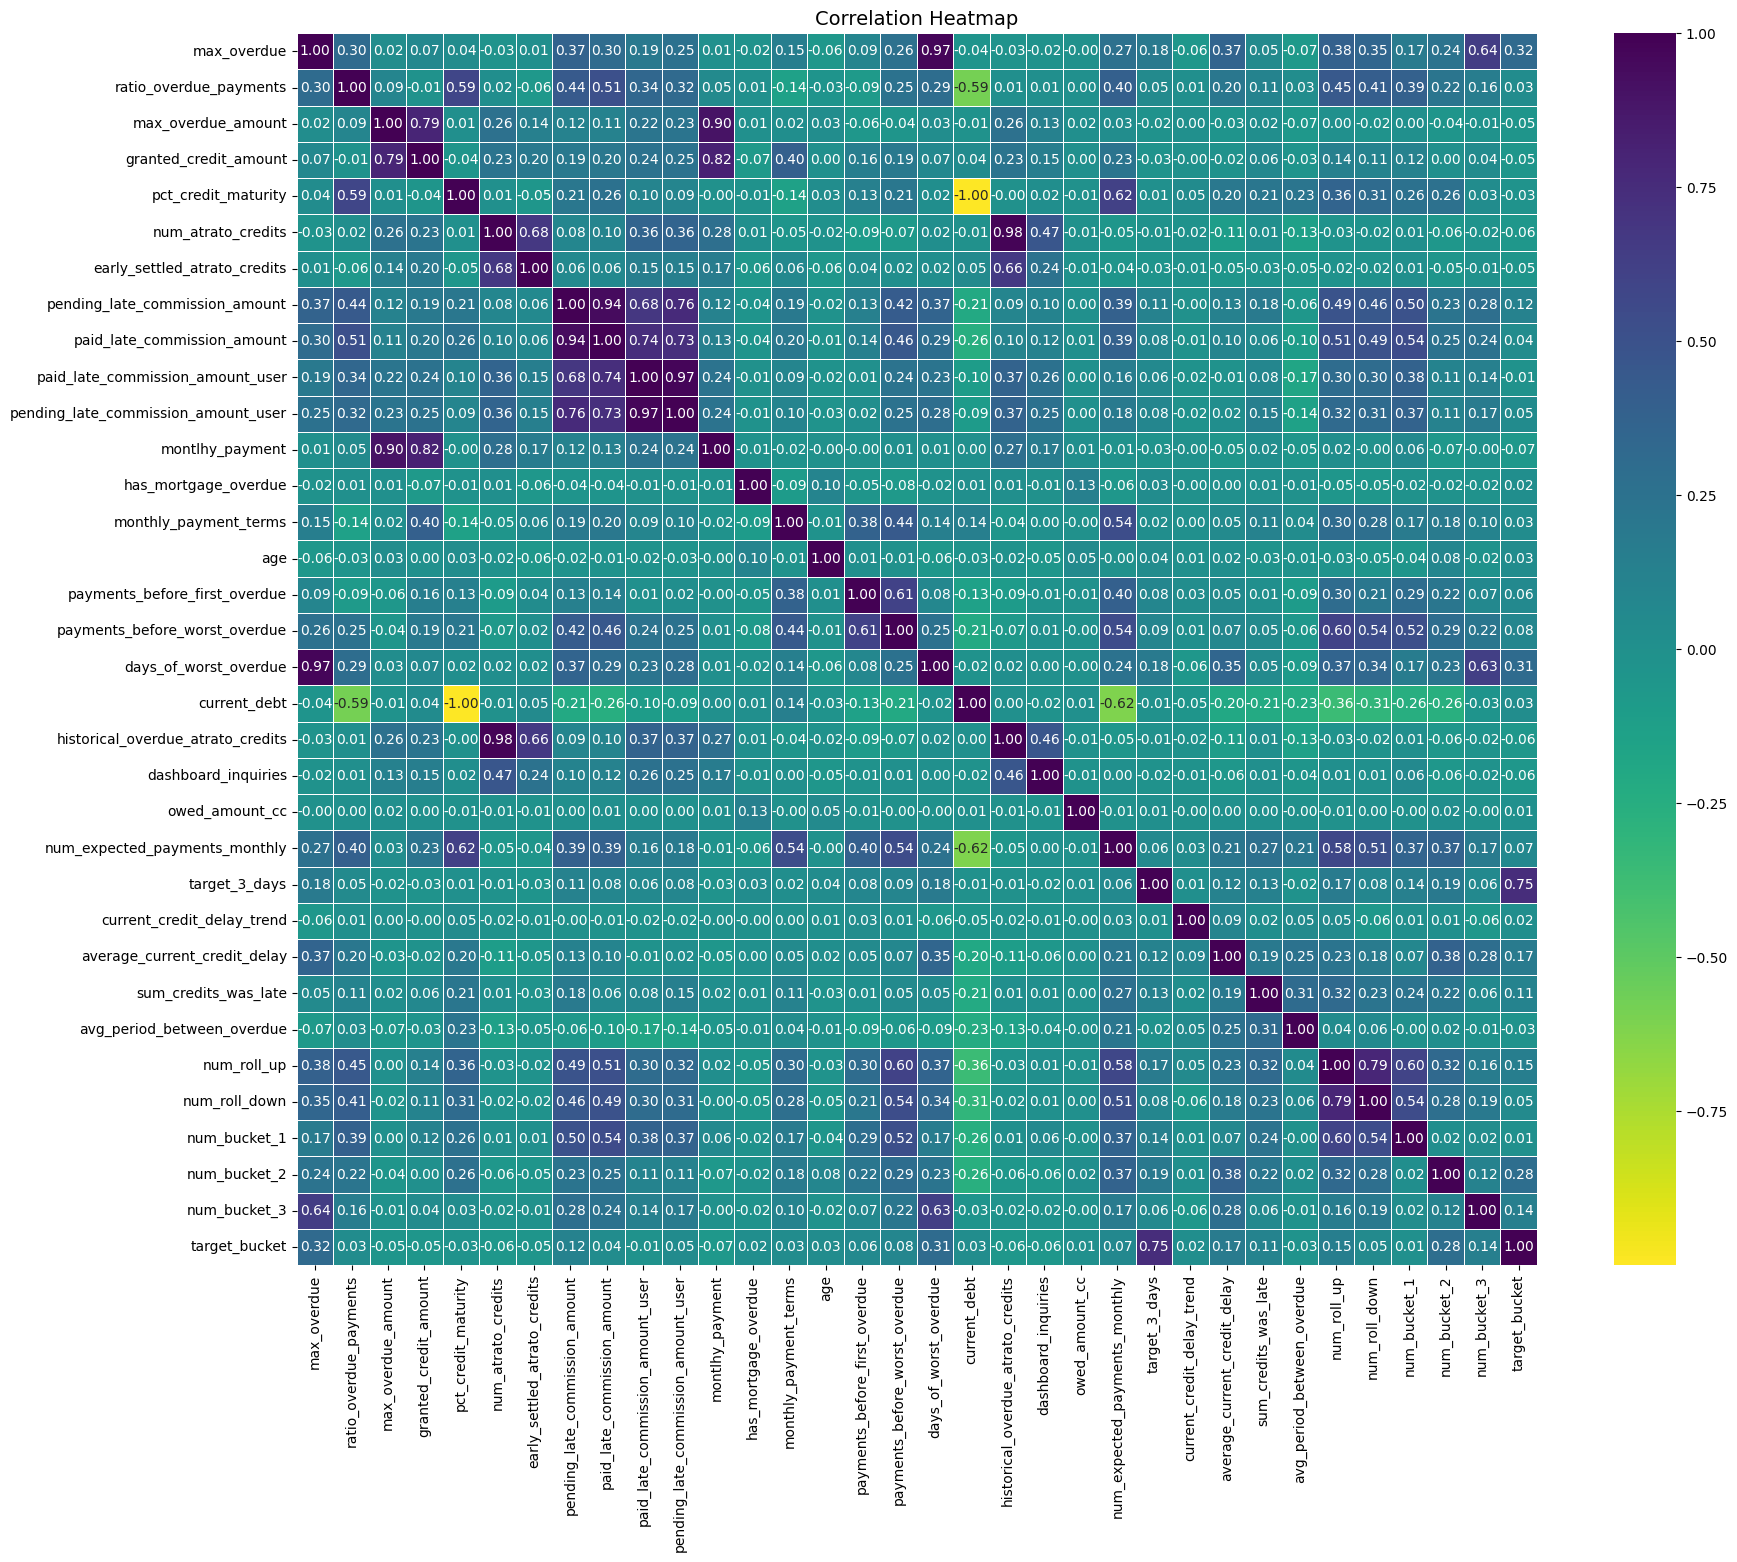

In [272]:
plt.figure(figsize=(20, 16))  
plt.title('Correlation Heatmap', fontsize=14)

sns.heatmap(df_corr.corr(), annot=True, 
            fmt=".2f",  # Limita a dos decimales
            cmap='viridis_r', linecolor='white', linewidths=0.5, 
            annot_kws={"size": 10}  # size font annot
            )

plt.xticks(rotation=90, fontsize=10) 
plt.yticks(fontsize=10)
plt.show()


***

## <font color='#8789ed' face='Tahoma' size=5>Análisis de <font color='#8789ed' face='Monaco' size=4>target_3_days y target_bucket</font> </font>

<font color='#b33b3b' face='Monaco' size=4>target_3_days</font> 

<font face='Arial' size=3>Revisar los valores y proporciones que tenemos en nuestro target</font>

- <font face='Arial' size=3>0: no entran a bucket 1 de cobranza</font>
- <font face='Arial' size=3>1: entran a bucket 1 de cobranza</font>





In [273]:
df['target_3_days'].value_counts(normalize=True)*100

target_3_days
1    77.418505
0    22.581495
Name: proportion, dtype: float64

In [274]:
df['target_3_days'].isnull().sum() / len(df)

0.0

<font color='#b33b3b' face='Monaco' size=4>target_bucket</font> 

<font face='Arial' size=3>Revisar los valores y proporciones que tenemos en nuestro target</font>

- <font face='Arial' size=3>0: no entran a bucket 1 de cobranza</font>
- <font face='Arial' size=3>1: entran a bucket 1 de cobranza</font>
- <font face='Arial' size=3>2: entran a bucket 2 de cobranza</font>
- <font face='Arial' size=3>3: entran a bucket 3 de cobranza</font>

In [275]:
df['target_bucket'].value_counts(normalize=True)*100

target_bucket
1    36.152179
2    30.840506
0    22.581495
3    10.425820
Name: proportion, dtype: float64

In [276]:
df['target_bucket'].isnull().sum() / len(df)

0.0

### <font color='#8789ed' face='Tahoma' size=5>Análisis de <font color='#8789ed' face='Monaco' size=4>payment_history</font>  vs. <font color='#8789ed' face='Monaco' size=4>target_3_days</font> </font>


<font color='#b33b3b' face='Monaco' size=4>payment_history</font> 

<font face='Arial' size=3>Revisión de los valores y proporciones en payment_history</font> 

<font face='Arial' size=3>Nos da un array con una serie de números, cada número indica cuántos días se atraso en ese pago. El total del conteo de número indica el total de número de pagos que ha hecho. Nos explica cuánto se ha atrasado o adelantado en cada pago.</font> 

- <font face='Arial' size=3>Números negativos indican que pagó antes de su fecha (pago anticipado)</font>
- <font face='Arial' size=3>Números positivos indican que pagó después de su fecha (pago atrasado)</font>


In [277]:
# conteo de nulos en dataframe completo
df['payment_history'].isnull().sum()

18845

In [278]:
# proporciíon de nulos en dataframe completo
(df['payment_history'].isnull().sum() / len(df))*100

11.279973184250537

In [279]:
# hacemos un df de solo los que tienen payment_hist nulo
null_pay_hist = df[(df['payment_history'].isna())]

# checamos los conteos en target (debería ser nulo ???)
null_pay_hist['target_3_days'].value_counts()

target_3_days
1    14229
0     4616
Name: count, dtype: int64

In [280]:
# conteo de nulos en dataframe completo
df['target_3_days'].isnull().sum()

0

<font face='Arial' size=3>No hay nulos en <font color='#b33b3b' face='Monaco' size=2>target_3_days</font>  

Las variables que salen de este análisis traen nulos cuando el payment history es nulo, se analizarán mediante bivariados para su correcto llenado, ya que estos créditos pueden caer en first payment default y es de interés segmentarlos correctamente.

In [281]:
df['credito_created_at_utc'][df['payment_history'].isna()]

39        2020-11-23 21:05:47.000
48        2021-03-20 01:54:30.000
51        2020-08-28 18:37:23.000
52        2020-08-28 18:37:23.000
59        2020-09-22 11:19:31.000
                   ...           
167061    2024-10-01 19:34:59.000
167062    2024-10-01 01:31:37.000
167063    2024-10-09 01:58:02.000
167064    2024-10-19 00:52:27.000
167065    2024-10-28 23:01:35.000
Name: credito_created_at_utc, Length: 18845, dtype: object

In [282]:
df[(df['payment_history'].isna())&(df['credito_created_at_utc']<'2021-03')].shape[0]/len(df[df['payment_history'].isna()])*100

0.5996285486866543

In [283]:
df[(df['payment_history'].isna())&(df['credito_created_at_utc']<'2021')]['target_3_days'].value_counts(normalize=True)

target_3_days
1    0.858824
0    0.141176
Name: proportion, dtype: float64

In [284]:
df[(df['payment_history'].isna())&(df['credito_created_at_utc']<'2022')&(df['credito_created_at_utc']>'2020')].shape[0]/len(df[df['payment_history'].isna()])*100

6.643672061554789

In [285]:
df[(df['payment_history'].isna())&(df['credito_created_at_utc']<'2022')&(df['credito_created_at_utc']>'2020')].describe()

,id_solicitud,id_userv3,max_overdue,ratio_overdue_payments,max_overdue_amount,granted_credit_amount,pct_credit_maturity,num_atrato_credits,early_settled_atrato_credits,pending_late_commission_amount,paid_late_commission_amount,paid_late_commission_amount_user,pending_late_commission_amount_user,montlhy_payment,has_mortgage_overdue,monthly_payment_terms,age,payments_before_first_overdue,payments_before_worst_overdue,days_of_worst_overdue,has_mortgage_or_large_loans,current_debt,historical_overdue_atrato_credits,dashboard_inquiries,owed_amount_cc,num_expected_payments_monthly,target_3_days,current_credit_delay_trend,average_current_credit_delay,sum_credits_was_late,avg_period_between_overdue,num_roll_up,num_roll_down,num_bucket_1,num_bucket_2,num_bucket_3,target_bucket
count,1252.000000,1252.000000,70.000000,70.000000,70.000000,1252.000000,223.000000,1252.000000,32.000000,11.000000,5.0,22.000000,22.000000,1252.000000,145.000000,1252.000000,1252.000000,70.000000,70.000000,70.000000,145.0,223.000000,144.000000,0.0,1.224000e+03,1252.000000,1252.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1252.000000
mean,86250.987220,26431.786741,15.971429,0.107043,1122.478429,10977.902508,0.097578,1.119808,1.031250,163.636364,150.0,217.885000,217.885000,1422.307108,0.124138,10.489617,33.732428,3.071429,3.485714,16.071429,1.0,0.902453,1.027778,NaN,8.374185e+03,1.504792,0.700479,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.394569
std,48168.211915,23056.574193,35.938341,0.066449,944.025203,11202.287711,0.101645,0.334565,0.176777,45.226702,0.0,136.860368,136.860368,1486.303223,0.330882,5.250623,10.828633,3.632867,4.060209,35.903381,0.0,0.101635,0.164909,NaN,5.295819e+04,1.610559,0.458231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.149526
min,3071.000000,34.000000,1.000000,0.042000,200.000000,1000.000000,0.000000,1.000000,1.000000,150.000000,150.0,144.600000,144.600000,79.190000,0.000000,1.000000,18.000000,0.000000,0.000000,1.000000,1.0,-0.000000,1.000000,NaN,0.000000e+00,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,46241.750000,6874.750000,1.000000,0.067000,541.822500,4104.250000,0.046500,1.000000,1.000000,150.000000,150.0,150.000000,150.000000,647.500000,0.000000,6.000000,25.000000,0.000000,0.000000,1.000000,1.0,0.864000,1.000000,NaN,0.000000e+00,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
50%,84543.500000,16174.500000,2.000000,0.083000,771.000000,7000.000000,0.066000,1.000000,1.000000,150.000000,150.0,150.000000,150.000000,1030.140000,0.000000,9.000000,31.000000,1.500000,1.500000,2.500000,1.0,0.934000,1.000000,NaN,0.000000e+00,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
75%,130441.000000,48242.000000,9.000000,0.111000,1344.250000,14700.000000,0.136000,1.000000,1.000000,150.000000,150.0,261.750000,261.750000,1692.992500,0.000000,12.000000,39.000000,6.000000,6.000000,9.000000,1.0,0.953500,1.000000,NaN,4.091000e+03,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000
max,175835.000000,78059.000000,170.000000,0.333000,5000.000000,100000.000000,1.000000,3.000000,2.000000,300.000000,150.0,600.000000,600.000000,22645.430000,1.000000,40.000000,70.000000,16.000000,16.000000,170.000000,1.0,1.000000,2.000000,NaN,1.573324e+06,16.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.000000


***

## <font color='#8789ed' face='Tahoma' size=5>Exploración de variables</font> 

<font face='Arial' size=3>Es importante tomar en cuenta que por ahora se pueden hacer dos aproximaciones:</font> 

1. <font face='Arial' size=3>Cada registro que entre al entrenamiento corresponde a un usuario.</font> 
2. <font face='Arial' size=3>Cada registro que entra al entrenamiento corresponde a un crédito.</font> 


In [286]:
len(df)

167066

In [287]:
# hacemos un df de solo los que tienen payment_hist con valor
#df = df[~(df['payment_history'].isna())]
len(df)


167066

In [288]:
df['target_3_days'].value_counts()

target_3_days
1    129340
0     37726
Name: count, dtype: int64

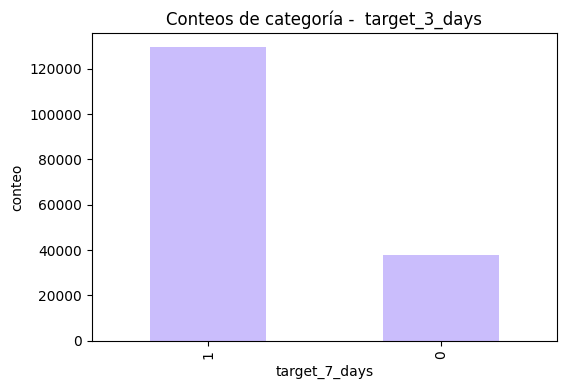

In [289]:
plt.figure(figsize=(6, 4))
df['target_3_days'].value_counts().plot(kind='bar' , color='#cabdfc')
plt.title(f'Conteos de categoría -  {'target_3_days'}')
plt.xlabel('target_7_days')
plt.ylabel('conteo')
plt.xticks(rotation=90)
plt.show()

In [290]:
# id_userv3 es el usuario que llega a hacer solicitud (un solo user puede tener varios idsolicitud)
df['id_userv3'].unique().shape

(39606,)

In [291]:
df['num_atrato_credits'].value_counts()

num_atrato_credits
1.0     92678
2.0     40171
3.0     19734
4.0      8446
5.0      3669
6.0      1401
7.0       548
8.0       249
9.0        64
10.0       48
12.0       10
11.0        8
15.0        2
17.0        2
16.0        1
13.0        1
Name: count, dtype: int64

In [292]:
# 2 usuarios tienen hasta 17 créditos
df[df['num_atrato_credits']==17]

,idobservation,id_solicitud,id_userv3,payment_history,max_overdue,ratio_overdue_payments,max_overdue_amount,granted_credit_amount,pct_credit_maturity,risk_profile_v1,risk_profile_v2,num_atrato_credits,early_settled_atrato_credits,pending_late_commission_amount,paid_late_commission_amount,paid_late_commission_amount_user,pending_late_commission_amount_user,montlhy_payment,has_mortgage_overdue,monthly_payment_terms,age,gender,payments_before_first_overdue,payments_before_worst_overdue,days_of_worst_overdue,has_mortgage_or_large_loans,current_debt,historical_overdue_atrato_credits,dashboard_inquiries,most_used_paymentmethod,owed_amount_cc,num_expected_payments_monthly,target_3_days,credito_created_at_utc,current_credit_delay_trend,average_current_credit_delay,sum_credits_was_late,avg_period_between_overdue,num_roll_up,num_roll_down,num_bucket_1,num_bucket_2,num_bucket_3,target_bucket
141259,1697742-5,1697742,2426,"16,-7,0,17",16.0,0.333,2536.52,11000.0,0.704,B1,B1,17.0,14.0,300.0,300.0,1027.90,1027.90,2236.52,NaN,6,35,Hombre,0.0,8.0,16.0,NaN,0.296,17.0,521.0,Conekta-STP,0.0,5,1,2024-06-16 00:39:20.000,-5.666667,2.833333,1.0,0.50,1.0,1.0,2.0,0.0,0.0,1
141260,1697742-4,1697742,2426,"-7,0,17",1.0,0.167,2231.39,11000.0,0.529,B1,B1,17.0,14.0,300.0,NaN,580.42,880.42,2236.52,NaN,6,35,Hombre,1.0,1.0,2.0,NaN,0.471,17.0,509.0,NaN,0.0,4,1,2024-06-16 00:39:20.000,0.000000,0.000000,1.0,0.25,0.0,1.0,1.0,0.0,0.0,1


In [293]:
df['num_atrato_credits'].isna().sum()

34

In [294]:
features_list = list(df.columns)
features_list.remove('id_solicitud')
features_list.remove('id_userv3')
features_list.remove('idobservation')
features_list.remove('target_3_days')
features_list.remove('credito_created_at_utc')
features_list.remove('target_bucket')
features_list

['payment_history',
 'max_overdue',
 'ratio_overdue_payments',
 'max_overdue_amount',
 'granted_credit_amount',
 'pct_credit_maturity',
 'risk_profile_v1',
 'risk_profile_v2',
 'num_atrato_credits',
 'early_settled_atrato_credits',
 'pending_late_commission_amount',
 'paid_late_commission_amount',
 'paid_late_commission_amount_user',
 'pending_late_commission_amount_user',
 'montlhy_payment',
 'has_mortgage_overdue',
 'monthly_payment_terms',
 'age',
 'gender',
 'payments_before_first_overdue',
 'payments_before_worst_overdue',
 'days_of_worst_overdue',
 'has_mortgage_or_large_loans',
 'current_debt',
 'historical_overdue_atrato_credits',
 'dashboard_inquiries',
 'most_used_paymentmethod',
 'owed_amount_cc',
 'num_expected_payments_monthly',
 'current_credit_delay_trend',
 'average_current_credit_delay',
 'sum_credits_was_late',
 'avg_period_between_overdue',
 'num_roll_up',
 'num_roll_down',
 'num_bucket_1',
 'num_bucket_2',
 'num_bucket_3']

In [295]:
len(features_list)

38

***
## <font color='#78acf0' face='Optima' size=5>Numeric Features</font> 

<font face='Arial' size=3>Establecemos una lista de las features numéricas para analizarlas en conjunto en la generalidad e ir revisando a detalle cada una. Este nuevo dataset nos permite generar gráficas usando una función y así observar qué variables pueden ser conflictivas.</font> 




In [296]:
df

,idobservation,id_solicitud,id_userv3,payment_history,max_overdue,ratio_overdue_payments,max_overdue_amount,granted_credit_amount,pct_credit_maturity,risk_profile_v1,risk_profile_v2,num_atrato_credits,early_settled_atrato_credits,pending_late_commission_amount,paid_late_commission_amount,paid_late_commission_amount_user,pending_late_commission_amount_user,montlhy_payment,has_mortgage_overdue,monthly_payment_terms,age,gender,payments_before_first_overdue,payments_before_worst_overdue,days_of_worst_overdue,has_mortgage_or_large_loans,current_debt,historical_overdue_atrato_credits,dashboard_inquiries,most_used_paymentmethod,owed_amount_cc,num_expected_payments_monthly,target_3_days,credito_created_at_utc,current_credit_delay_trend,average_current_credit_delay,sum_credits_was_late,avg_period_between_overdue,num_roll_up,num_roll_down,num_bucket_1,num_bucket_2,num_bucket_3,target_bucket
0,3050-25,3050,6110,"1,9,2,1,3,1,3,3,0,1,9,4,2,1,0",9.0,0.433,640.00000,13500.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1275.705627,NaN,15,42,Hombre,14.0,54.0,9.0,NaN,NaN,1.0,NaN,NaN,0.0,12,1,2020-08-28 18:37:16.000,1.666667,3.428571,1.0,1.0,2.0,2.0,2.0,0.0,0.0,1
1,3050-20,3050,6110,"1,3,3,0,1,9,4,2,1,0",9.0,0.267,640.00000,13500.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1275.705627,NaN,15,42,Hombre,17.0,56.0,9.0,NaN,NaN,1.0,NaN,NaN,0.0,10,0,2020-08-28 18:37:16.000,0.875000,1.900000,1.0,0.5,1.0,1.0,1.0,0.0,0.0,0
2,3094-10,3094,6115,"1,-1,0,1",1.0,0.111,1943.00000,23000.0,0.173,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1942.025523,NaN,18,31,Hombre,2.0,2.0,1.0,NaN,0.827,1.0,NaN,NaN,0.0,10,1,2020-08-28 18:38:39.000,-1.000000,0.500000,1.0,1.5,0.0,0.0,0.0,0.0,0.0,1
3,3269-11,3269,6120,"0,0,0,0",NaN,NaN,NaN,15000.0,0.295,NaN,NaN,1.0,NaN,150.0,150.0,150.0,150.0,1305.342020,NaN,18,40,Hombre,NaN,NaN,NaN,NaN,0.705,1.0,NaN,NaN,0.0,11,0,2020-08-28 18:40:01.000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,3269-12,3269,6120,"3,0,0,0,0",3.0,0.056,1455.34202,15000.0,0.356,NaN,NaN,1.0,NaN,300.0,300.0,300.0,300.0,1305.342020,NaN,18,40,Hombre,18.0,18.0,3.0,NaN,0.644,1.0,NaN,BBVA Practicaja,0.0,12,1,2020-08-28 18:40:01.000,0.000000,0.500000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167061,1859986-1,1859986,685667,NaN,NaN,NaN,NaN,3130.0,0.120,B2,C2,1.0,NaN,NaN,NaN,NaN,NaN,781.960000,0.0,6,34,Hombre,NaN,NaN,NaN,1.0,0.880,NaN,41.0,OxxoPay,0.0,1,1,2024-10-01 19:34:59.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
167062,1862383-1,1862383,187812,NaN,NaN,NaN,NaN,20000.0,0.043,C2,B1,4.0,NaN,NaN,NaN,150.0,150.0,2860.200000,1.0,9,48,Mujer,NaN,NaN,NaN,1.0,0.957,3.0,59.0,NaN,39272.0,0,1,2024-10-01 01:31:37.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
167063,1877366-1,1877366,431383,NaN,NaN,NaN,NaN,10000.0,NaN,B3,B1,2.0,NaN,300.0,NaN,300.0,300.0,970.570000,NaN,18,39,Hombre,NaN,NaN,NaN,NaN,NaN,1.0,63.0,NaN,0.0,1,1,2024-10-09 01:58:02.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
167064,1896273-1,1896273,699542,NaN,NaN,NaN,NaN,9364.0,NaN,A2,B1,1.0,NaN,300.0,NaN,NaN,NaN,1104.690000,0.0,12,36,Mujer,NaN,NaN,NaN,1.0,NaN,NaN,4.0,NaN,0.0,1,0,2024-10-19 00:52:27.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [502]:
numeric_features = ['max_overdue','ratio_overdue_payments','max_overdue_amount','granted_credit_amount','pct_credit_maturity', 'num_atrato_credits','early_settled_atrato_credits',
                    'pending_late_commission_amount','paid_late_commission_amount','paid_late_commission_amount_user', 'pending_late_commission_amount_user',
                    'montlhy_payment','has_mortgage_overdue' ,'monthly_payment_terms','age','payments_before_first_overdue',
                    'payments_before_worst_overdue','days_of_worst_overdue','has_mortgage_or_large_loans',
                    'current_debt','historical_overdue_atrato_credits','dashboard_inquiries',
                    'owed_amount_cc','num_expected_payments_monthly','current_credit_delay_trend','average_current_credit_delay','sum_credits_was_late','avg_period_between_overdue',
                    'num_roll_up','num_roll_down','num_bucket_1','num_bucket_2','num_bucket_3']

numeric_features

['max_overdue',
 'ratio_overdue_payments',
 'max_overdue_amount',
 'granted_credit_amount',
 'pct_credit_maturity',
 'num_atrato_credits',
 'early_settled_atrato_credits',
 'pending_late_commission_amount',
 'paid_late_commission_amount',
 'paid_late_commission_amount_user',
 'pending_late_commission_amount_user',
 'montlhy_payment',
 'has_mortgage_overdue',
 'monthly_payment_terms',
 'age',
 'payments_before_first_overdue',
 'payments_before_worst_overdue',
 'days_of_worst_overdue',
 'has_mortgage_or_large_loans',
 'current_debt',
 'historical_overdue_atrato_credits',
 'dashboard_inquiries',
 'owed_amount_cc',
 'num_expected_payments_monthly',
 'current_credit_delay_trend',
 'average_current_credit_delay',
 'sum_credits_was_late',
 'avg_period_between_overdue',
 'num_roll_up',
 'num_roll_down',
 'num_bucket_1',
 'num_bucket_2',
 'num_bucket_3']

In [503]:
len(numeric_features)

33

In [504]:
df_numeric = df[numeric_features]
df_numeric


,max_overdue,ratio_overdue_payments,max_overdue_amount,granted_credit_amount,pct_credit_maturity,num_atrato_credits,early_settled_atrato_credits,pending_late_commission_amount,paid_late_commission_amount,paid_late_commission_amount_user,pending_late_commission_amount_user,montlhy_payment,has_mortgage_overdue,monthly_payment_terms,age,payments_before_first_overdue,payments_before_worst_overdue,days_of_worst_overdue,has_mortgage_or_large_loans,current_debt,historical_overdue_atrato_credits,dashboard_inquiries,owed_amount_cc,num_expected_payments_monthly,current_credit_delay_trend,average_current_credit_delay,sum_credits_was_late,avg_period_between_overdue,num_roll_up,num_roll_down,num_bucket_1,num_bucket_2,num_bucket_3
0,9.0,0.433,640.00000,13500.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1275.705627,NaN,15,42,14.0,54.0,9.0,NaN,NaN,1.0,NaN,0.0,12,1.666667,3.428571,1.0,1.0,2.0,2.0,2.0,0.0,0.0
1,9.0,0.267,640.00000,13500.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1275.705627,NaN,15,42,17.0,56.0,9.0,NaN,NaN,1.0,NaN,0.0,10,0.875000,1.900000,1.0,0.5,1.0,1.0,1.0,0.0,0.0
2,1.0,0.111,1943.00000,23000.0,0.173,1.0,NaN,NaN,NaN,NaN,NaN,1942.025523,NaN,18,31,2.0,2.0,1.0,NaN,0.827,1.0,NaN,0.0,10,-1.000000,0.500000,1.0,1.5,0.0,0.0,0.0,0.0,0.0
3,NaN,NaN,NaN,15000.0,0.295,1.0,NaN,150.0,150.0,150.0,150.0,1305.342020,NaN,18,40,NaN,NaN,NaN,NaN,0.705,1.0,NaN,0.0,11,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,0.056,1455.34202,15000.0,0.356,1.0,NaN,300.0,300.0,300.0,300.0,1305.342020,NaN,18,40,18.0,18.0,3.0,NaN,0.644,1.0,NaN,0.0,12,0.000000,0.500000,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167061,NaN,NaN,NaN,3130.0,0.120,1.0,NaN,NaN,NaN,NaN,NaN,781.960000,0.0,6,34,NaN,NaN,NaN,1.0,0.880,NaN,41.0,0.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
167062,NaN,NaN,NaN,20000.0,0.043,4.0,NaN,NaN,NaN,150.0,150.0,2860.200000,1.0,9,48,NaN,NaN,NaN,1.0,0.957,3.0,59.0,39272.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
167063,NaN,NaN,NaN,10000.0,NaN,2.0,NaN,300.0,NaN,300.0,300.0,970.570000,NaN,18,39,NaN,NaN,NaN,NaN,NaN,1.0,63.0,0.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
167064,NaN,NaN,NaN,9364.0,NaN,1.0,NaN,300.0,NaN,NaN,NaN,1104.690000,0.0,12,36,NaN,NaN,NaN,1.0,NaN,NaN,4.0,0.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### <font color='sky blue' face='Optima' size=4>Correlation Chart</font> 


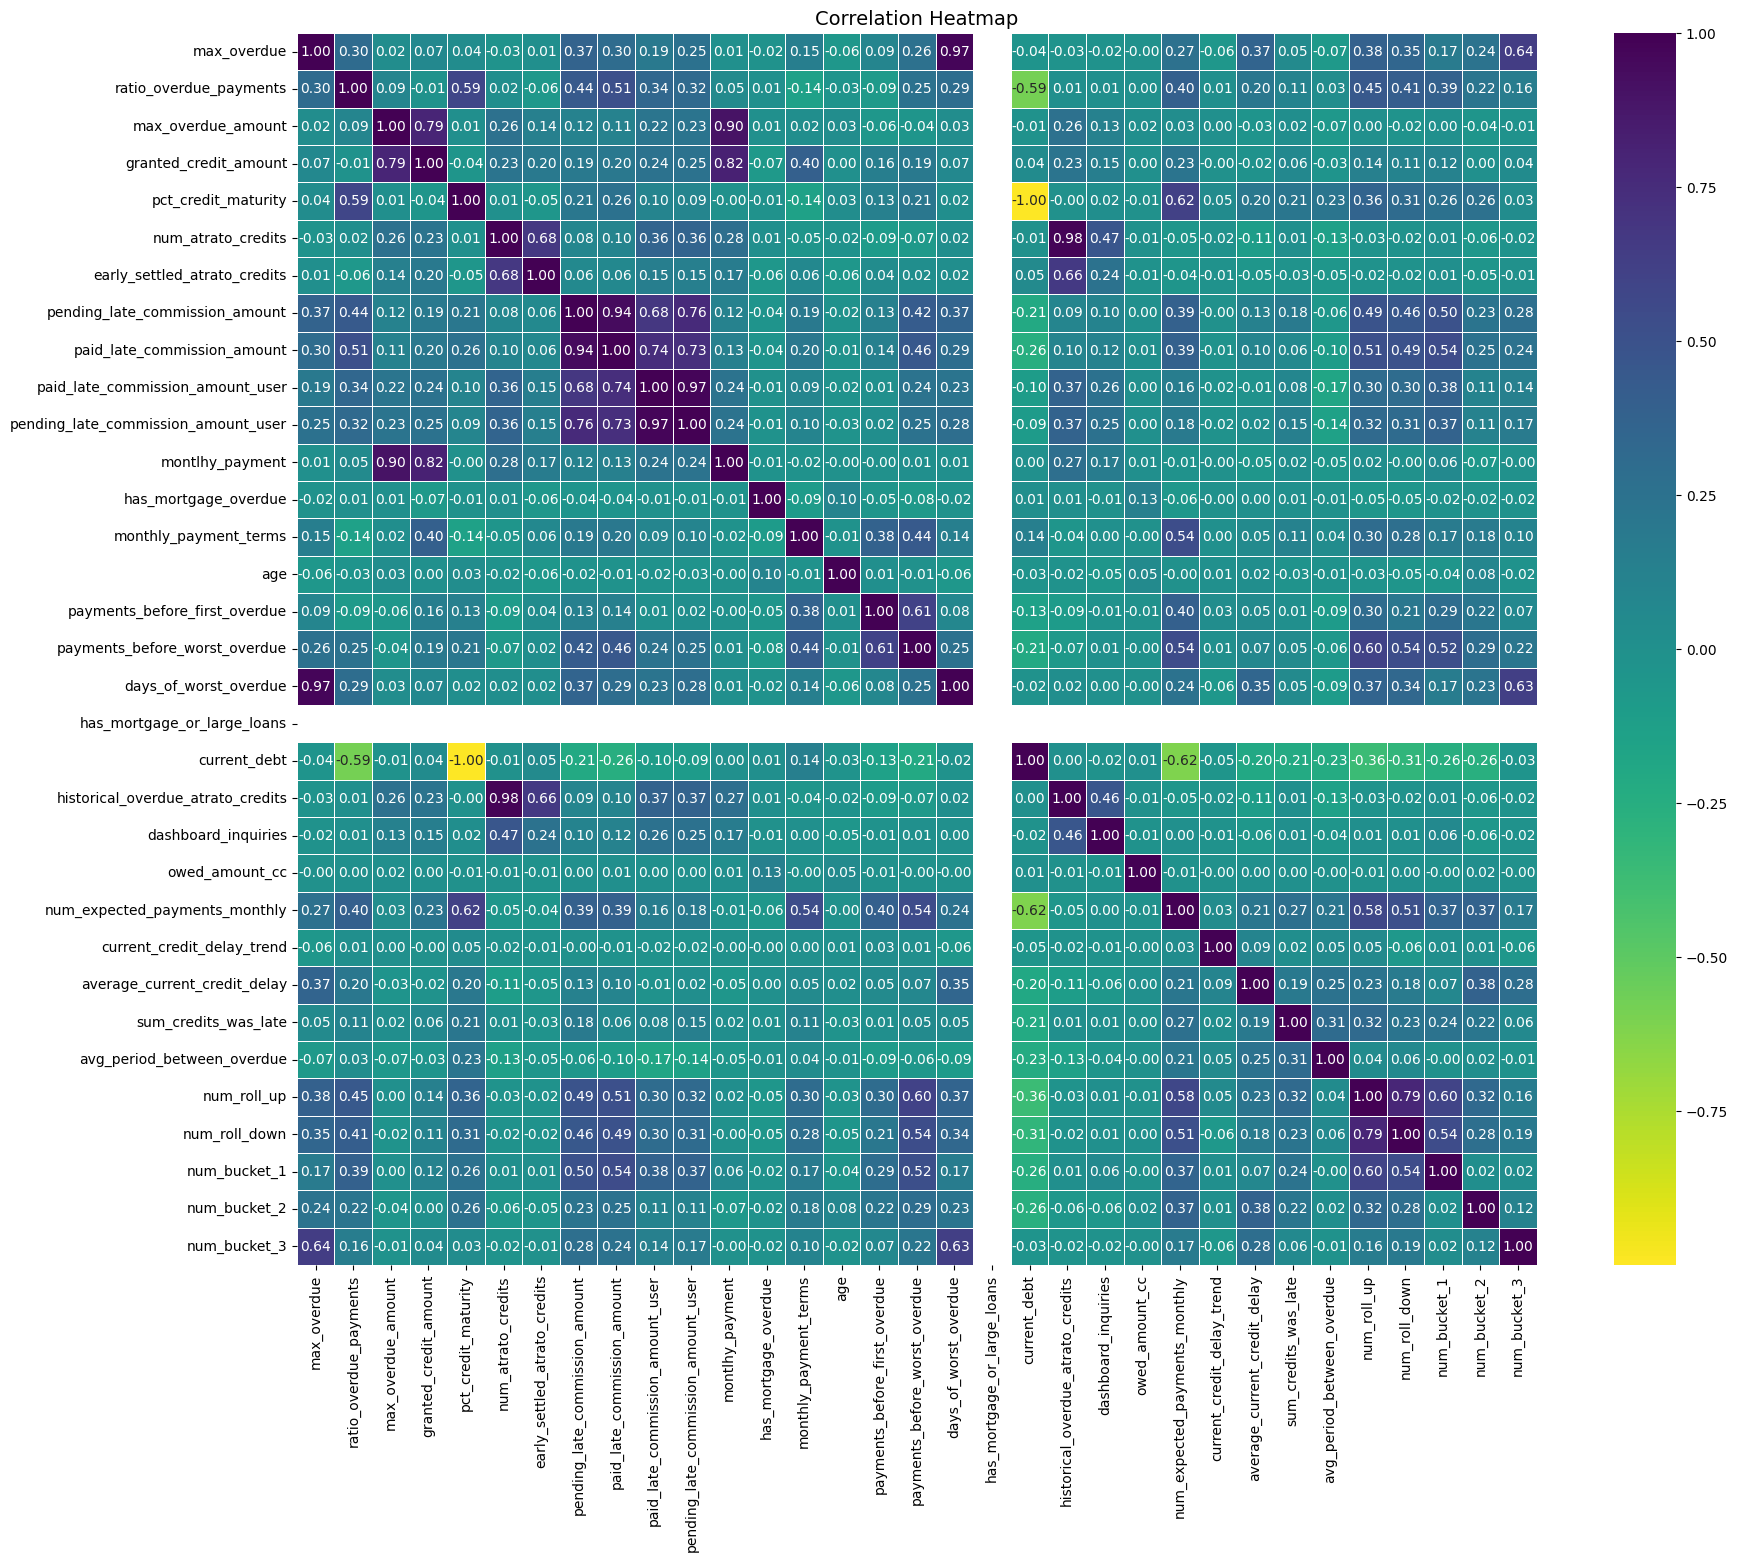

In [505]:
plt.figure(figsize=(20, 16))  
plt.title('Correlation Heatmap', fontsize=14)

sns.heatmap(df_numeric.corr(), annot=True, 
            fmt=".2f",  # 2 decimales
            cmap='viridis_r', linecolor='white', linewidths=0.5, 
            annot_kws={"size": 10}  # size font annot
            )

plt.xticks(rotation=90, fontsize=10) 
plt.yticks(fontsize=10)
plt.show()

### <font color='sky blue' face='Optima' size=4>Numeric Cols Null Volume</font> 


In [506]:
get_missing_report(df_numeric)

,columns,missingPercentage,type
12,has_mortgage_overdue,85.284259,float64
18,has_mortgage_or_large_loans,85.284259,float64
6,early_settled_atrato_credits,84.664145,float64
8,paid_late_commission_amount,53.481259,float64
9,paid_late_commission_amount_user,43.907797,float64
7,pending_late_commission_amount,40.473825,float64
10,pending_late_commission_amount_user,37.337938,float64
0,max_overdue,30.502316,float64
17,days_of_worst_overdue,30.502316,float64
1,ratio_overdue_payments,30.502316,float64


### <font color='sky blue' face='Optima' size=4>Numeric Cols Distribution</font> 


/tmp/ipykernel_768/812718564.py:11: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df_numeric, x=col, color='purple', fill=True, ax=axes[i])


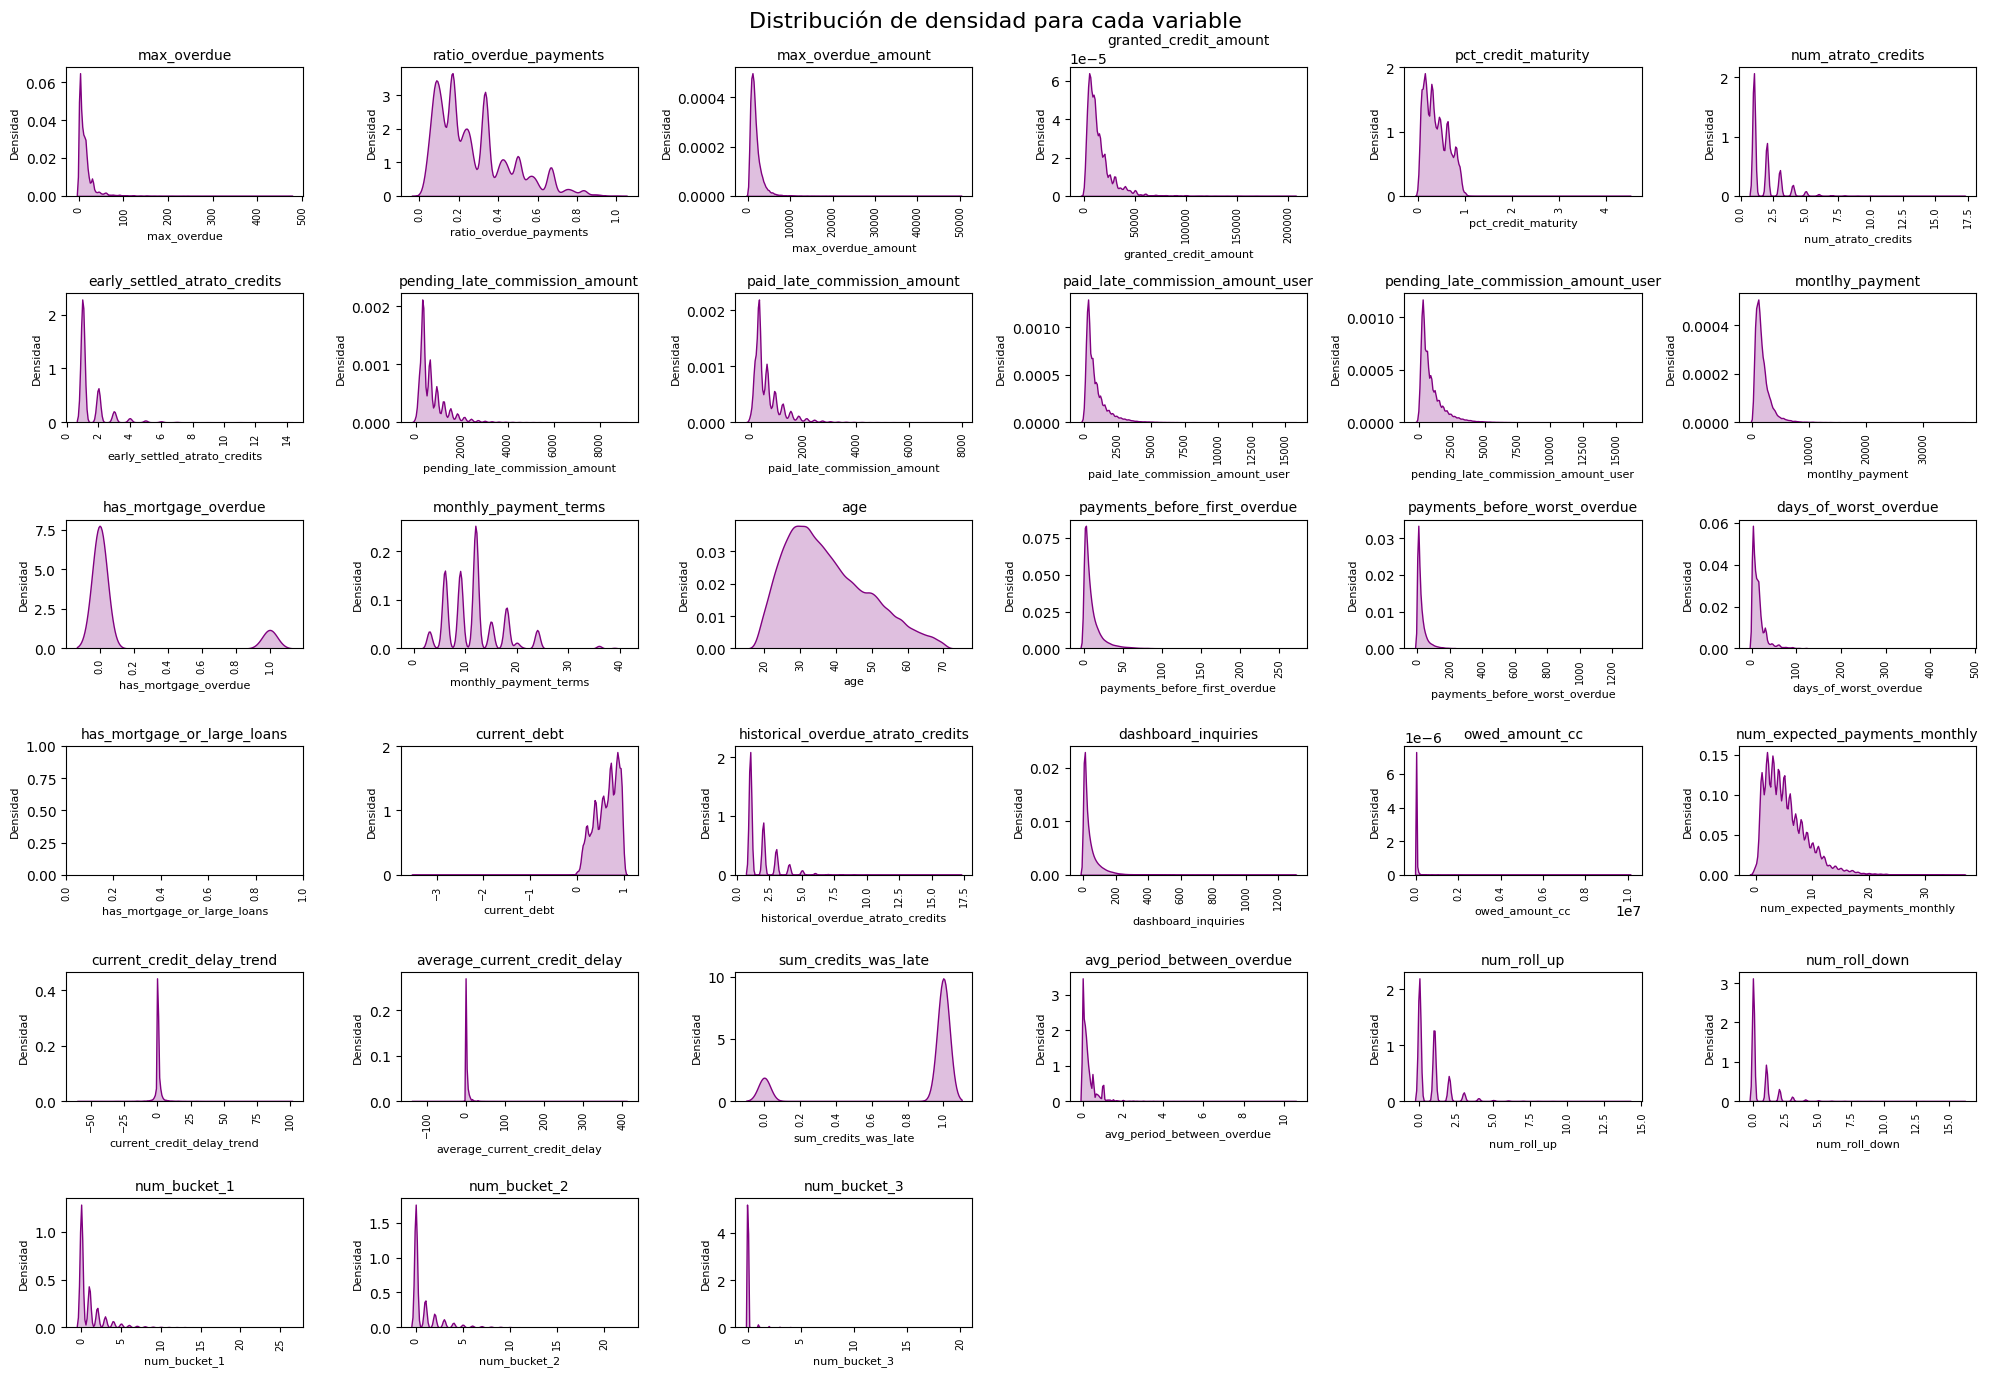

In [508]:
import matplotlib.pyplot as plt
import seaborn as sns

n_cols = 6
n_rows = 6

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 14)) 
fig.suptitle('Distribución de densidad para cada variable', fontsize=16)
axes = axes.flatten() 
for i, col in enumerate(df_numeric.columns):
    sns.kdeplot(data=df_numeric, x=col, color='purple', fill=True, ax=axes[i])
    axes[i].set_title(f'{col}', fontsize=10)
    axes[i].set_xlabel(col, fontsize=8)
    axes[i].set_ylabel('Densidad', fontsize=8)
    axes[i].tick_params(axis='x', rotation=90, labelsize=7)

# Oculta cualquier subfigura vacía 
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


#### <font color='#b33b3b' face='Monaco' size=5>max_overdue</font> 

<font face='Arial' size=3>Máximo número de días atrasado (actual crédito)</font> 

<font face='Arial' size=3>Los montos negativos representan que pagó ese número de días antes de su fecha</font> 



In [303]:
df_numeric['max_overdue'].describe()

count    116107.000000
mean         14.009870
std          19.026775
min           1.000000
25%           3.000000
50%           9.000000
75%          17.000000
max         473.000000
Name: max_overdue, dtype: float64

In [304]:
len(df_numeric[df_numeric['max_overdue']<1])/len(df_numeric)*100

0.0

In [305]:
# iqr para determinar 'normalidad'
IQR = df_numeric['max_overdue'].describe()[6]-df_numeric['max_overdue'].describe()[4]
rango = [df_numeric['max_overdue'].describe()[4]-IQR*1.5, df_numeric['max_overdue'].describe()[6]+IQR*1.5]
print(rango)

[-18.0, 38.0]


/tmp/ipykernel_768/1354835366.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  IQR = df_numeric['max_overdue'].describe()[6]-df_numeric['max_overdue'].describe()[4]
/tmp/ipykernel_768/1354835366.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  IQR = df_numeric['max_overdue'].describe()[6]-df_numeric['max_overdue'].describe()[4]
/tmp/ipykernel_768/1354835366.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rango = [df_numeri

<font face='Arial' size=3>Consideramos normal de -9 a 15 días de atraso</font> 

<font face='Arial' size=3>Revisión de atrasados más de 15 dias</font> 



In [306]:
# cantidad de registros con atraso mayor a 15 dias
len(df_numeric[df_numeric['max_overdue']>15])

32365

In [307]:
# proporción de registros con atraso mayor a 15 dias
len(df_numeric[df_numeric['max_overdue']>15]) / len(df_numeric)*100

19.372583290436115

In [308]:
# media de días de atraso en mayor a 15 dias
df_numeric[df_numeric['max_overdue']>15]['max_overdue'].mean()

34.51985169164221

In [309]:
# máximo de días de atraso en mayor a 15 dias
df_numeric[df_numeric['max_overdue']>15]['max_overdue'].max()

473.0

In [310]:
# mínimo de días de atraso en mayor a 15 dias
df_numeric[df_numeric['max_overdue']>15]['max_overdue'].min()

16.0

In [311]:
df_numeric[df_numeric['max_overdue']>15]['max_overdue'].describe()

count    32365.000000
mean        34.519852
std         25.691011
min         16.000000
25%         19.000000
50%         26.000000
75%         38.000000
max        473.000000
Name: max_overdue, dtype: float64

In [312]:
len(df_numeric[df_numeric['max_overdue']>81])

1875

In [313]:
len(df_numeric[df_numeric['max_overdue']>81])/len(df_numeric)*100

1.1223109429806184

<font face='Arial' size=3>Revisión de atrasados menos de -9 dias</font> 


In [314]:
# cantidad de registros con anticipación mayor a 9 dias
len(df_numeric[df_numeric['max_overdue']<-9])

0

In [315]:
# proporción de registros con anticipación mayor a 9 dias
len(df_numeric[df_numeric['max_overdue']<-9]) / len(df_numeric) *100

0.0

In [316]:
# media de días de anticipación mayor a 9 dias
df_numeric[df_numeric['max_overdue']<-9]['max_overdue'].mean()

nan

In [317]:
# mínimo de días de anticipación mayor a 9 dias
df_numeric[df_numeric['max_overdue']<-9]['max_overdue'].max()

nan

In [318]:
# máximo de días de anticipación mayor a 9 dias
df_numeric[df_numeric['max_overdue']<-9]['max_overdue'].min()

nan

In [319]:
df_numeric[df_numeric['max_overdue']<-9]['max_overdue'].describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: max_overdue, dtype: float64

In [320]:
len(df_numeric[df_numeric['max_overdue']<-23])

0

In [321]:
len(df_numeric[df_numeric['max_overdue']<-23])/len(df_numeric)*100

0.0

#### <font color='#b33b3b' face='Monaco' size=5>days_of_worst_overdue</font> 

<font face='Arial' size=3>Número de días de su peor atraso (de este crédito para atrás, incluye crédito actual pero no última parcialidad pagada)</font> 

<font face='Arial' size=3>Winner vs. max_overdue</font> 


<font face='Arial' size=3>Los montos negativos representan que pagó ese número de días antes de su fecha</font> 



In [322]:
df_numeric['days_of_worst_overdue'].describe()

count    116107.000000
mean         14.890575
std          19.231624
min           1.000000
25%           3.000000
50%          10.000000
75%          18.000000
max         473.000000
Name: days_of_worst_overdue, dtype: float64

In [323]:
len(df_numeric[df_numeric['days_of_worst_overdue']<1])/len(df_numeric)*100

0.0

In [324]:
# iqr para determinar 'normalidad'
IQR = df_numeric['days_of_worst_overdue'].describe()[6]-df_numeric['days_of_worst_overdue'].describe()[4]
rango = [df_numeric['days_of_worst_overdue'].describe()[4]-IQR*1.5, df_numeric['days_of_worst_overdue'].describe()[6]+IQR*1.5]
print(rango)

[-19.5, 40.5]


/tmp/ipykernel_768/3668458543.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  IQR = df_numeric['days_of_worst_overdue'].describe()[6]-df_numeric['days_of_worst_overdue'].describe()[4]
/tmp/ipykernel_768/3668458543.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  IQR = df_numeric['days_of_worst_overdue'].describe()[6]-df_numeric['days_of_worst_overdue'].describe()[4]
/tmp/ipykernel_768/3668458543.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, 

<font face='Arial' size=3>Consideramos normal de 1 (minimo) a 44 días del peor atraso</font> 

<font face='Arial' size=3>Revisión de atrasos máximos de más de 44 dias</font> 



In [325]:
# cantidad de registros con atraso máximo mayor a 44 dias
len(df_numeric[df_numeric['days_of_worst_overdue']>44])

7093

In [326]:
# proporción de registros con atraso máximo mayor a 44 dias
len(df_numeric[df_numeric['days_of_worst_overdue']>44]) / len(df_numeric)*100

4.245627476566147

In [327]:
# media de días de atraso máximo mayor a 44 dias
df_numeric[df_numeric['days_of_worst_overdue']>44]['days_of_worst_overdue'].mean()

73.53291978006486

In [328]:
# máximo de días de atraso máximo mayor a 44 dias
df_numeric[df_numeric['days_of_worst_overdue']>44]['days_of_worst_overdue'].max()

473.0

In [329]:
# mínimo de días de atraso máximo mayor a 44 dias
df_numeric[df_numeric['days_of_worst_overdue']>44]['days_of_worst_overdue'].min()

45.0

In [330]:
df_numeric[df_numeric['days_of_worst_overdue']>44]['days_of_worst_overdue'].describe()

count    7093.000000
mean       73.532920
std        31.533126
min        45.000000
25%        53.000000
50%        62.000000
75%        85.000000
max       473.000000
Name: days_of_worst_overdue, dtype: float64

In [331]:
len(df_numeric[df_numeric['days_of_worst_overdue']>86])

1684

In [332]:
len(df_numeric[df_numeric['days_of_worst_overdue']>86])/len(df_numeric)*100

1.0079848682556596

<font face='Arial' size=3>No hay atrasos < 0 , en esta población no hay usuarios que tienen como peor atraso un pago anticipado.</font> 


#### <font color='#b33b3b' face='Monaco' size=5>ratio_overdue_payments</font> 

<font face='Arial' size=3>Periodos entre atrasos, veces que se atrasó / número de parcialidades del crédito actual</font> 




In [333]:
df_numeric['ratio_overdue_payments'].describe()

count    116107.000000
mean          0.274363
std           0.186872
min           0.014000
25%           0.111000
50%           0.222000
75%           0.375000
max           1.000000
Name: ratio_overdue_payments, dtype: float64

In [334]:
df_numeric['ratio_overdue_payments'].isnull().sum()

50959

In [335]:
df_numeric['ratio_overdue_payments'].isnull().sum()/len(df)*100

30.50231644978631

In [336]:
len(df_numeric[df_numeric['ratio_overdue_payments']>1])

0

In [337]:
len(df_numeric[df_numeric['ratio_overdue_payments']>1])/len(df_numeric)*100

0.0

#### <font color='#b33b3b' face='Monaco' size=5>max_overdue_amount</font> 

<font face='Arial' size=3>Máximo monto atrasado, este incluye la suma de comisiones, intereses moratorios, etc...</font> 

In [338]:
df_numeric['max_overdue_amount'].describe()

count    116138.000000
mean       1824.869409
std        1499.303213
min          13.350000
25%         927.810000
50%        1440.000000
75%        2216.000000
max       50000.000000
Name: max_overdue_amount, dtype: float64

In [339]:
# proporción de casos que tienen adeudo  máximo arriba de 5,000
len(df_numeric[df_numeric['max_overdue_amount']>5000])/len(df_numeric)*100

2.4277830318556735

In [340]:
# iqr para determinar 'normalidad'
IQR = df_numeric['max_overdue_amount'].describe()[6]-df_numeric['max_overdue_amount'].describe()[4]
rango = [df_numeric['max_overdue_amount'].describe()[4]-IQR*1.5, df_numeric['max_overdue_amount'].describe()[6]+IQR*1.5]
print(rango)

[-1004.4750000000001, 4148.285]


/tmp/ipykernel_768/4068100413.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  IQR = df_numeric['max_overdue_amount'].describe()[6]-df_numeric['max_overdue_amount'].describe()[4]
/tmp/ipykernel_768/4068100413.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  IQR = df_numeric['max_overdue_amount'].describe()[6]-df_numeric['max_overdue_amount'].describe()[4]
/tmp/ipykernel_768/4068100413.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.ilo

In [341]:
# proporción d ecasos que tienen adeudo  máximo arriba de 4,093 (límite superior de IQR)
len(df_numeric[df_numeric['max_overdue_amount']>4093])/len(df_numeric)*100

4.3144625477356255

<font face='Arial' size=3>Consideramos normal de 13.35 (mínimo) a 4,093 el monto de su máximo atraso</font> 

<font face='Arial' size=3>Revisión de montos mayores a 4,093 como máximo atraso</font> 



In [342]:
# cantidad de registros con monto máximo de atraso mayor a 4,093
len(df_numeric[df_numeric['max_overdue_amount']>4093])

7208

In [343]:
# cantidad de registros con monto máximo de atraso mayor a 4,093
len(df_numeric[df_numeric['max_overdue_amount']>4093])/ len(df_numeric)*100

4.3144625477356255

In [344]:
# media de monto en registros con monto máximo de atraso mayor a 4,093
df_numeric[df_numeric['max_overdue_amount']>4093]['max_overdue_amount'].mean()

6026.951293264994

In [345]:
# máximo de monto en registros con monto máximo de atraso mayor a 4,093
df_numeric[df_numeric['max_overdue_amount']>4093]['max_overdue_amount'].max()

50000.0

In [346]:
# mínimo de monto en registros con monto máximo de atraso mayor a 4,093
df_numeric[df_numeric['max_overdue_amount']>4093]['max_overdue_amount'].min()

4093.71

In [347]:
df_numeric[df_numeric['max_overdue_amount']>4093]['max_overdue_amount'].describe()

count     7208.000000
mean      6026.951293
std       2514.994271
min       4093.710000
25%       4552.877500
50%       5230.375000
75%       6500.000000
max      50000.000000
Name: max_overdue_amount, dtype: float64

In [348]:
len(df_numeric[df_numeric['max_overdue_amount']>6476.36])

1840

In [349]:
len(df_numeric[df_numeric['max_overdue_amount']>6476.36])/len(df_numeric)*100

1.1013611387116469

<font face='Arial' size=3>Revisión montos arriba de 6,476.36</font> 


In [350]:
# cantidad de registros con monto máximo de peor atraso arriba de 6,476.36
len(df_numeric[df_numeric['max_overdue_amount']>6476.36])

1840

In [351]:
# proporción de registros con monto máximo de peor atraso arriba de 6,476.36
len(df_numeric[df_numeric['max_overdue_amount']>6476.36])/ len(df_numeric) *100

1.1013611387116469

In [352]:
# media de monto en registros con monto máximo de peor atraso arriba de 6,476.36
df_numeric[df_numeric['max_overdue_amount']>6476.36]['max_overdue_amount'].mean()

9044.634412837466

In [353]:
# mínimo de monto en registros con monto máximo de peor atraso arriba de 6,476.36
df_numeric[df_numeric['max_overdue_amount']>6476.36]['max_overdue_amount'].min()

6482.84

In [354]:
# máximo de monto en registros con monto máximo de peor atraso arriba de 6,476.36
df_numeric[df_numeric['max_overdue_amount']>6476.36]['max_overdue_amount'].max()

50000.0

In [355]:
df_numeric[df_numeric['max_overdue_amount']>6476.36]['max_overdue_amount'].describe()

count     1840.000000
mean      9044.634413
std       3362.042567
min       6482.840000
25%       7098.819304
50%       8000.000000
75%      10000.000000
max      50000.000000
Name: max_overdue_amount, dtype: float64

In [356]:
comp = pd.DataFrame()
comp['max_overdue_amount'] = df_numeric['max_overdue_amount']
comp['granted_credit_amount'] = df_numeric['granted_credit_amount']
comp['montlhy_payment'] = df_numeric['montlhy_payment']
comp

,max_overdue_amount,granted_credit_amount,montlhy_payment
0,640.00000,13500.0,1275.705627
1,640.00000,13500.0,1275.705627
2,1943.00000,23000.0,1942.025523
3,NaN,15000.0,1305.342020
4,1455.34202,15000.0,1305.342020
...,...,...,...
167061,NaN,3130.0,781.960000
167062,NaN,20000.0,2860.200000
167063,NaN,10000.0,970.570000
167064,NaN,9364.0,1104.690000


In [357]:
# si es mayor a 1, debe más de 1 parcialidad , ratio de cuántamos mensualidades fueron su max cantidad atrasada
comp['max_overdue_amount_over_montlhy_payment']=comp['max_overdue_amount']/comp['montlhy_payment']

# sí puede ser mayor a 1, por suma de comisiones e intereses 
comp['max_overdue_amount_over_granted_amount']=comp['max_overdue_amount']/comp['granted_credit_amount']

comp

,max_overdue_amount,granted_credit_amount,montlhy_payment,max_overdue_amount_over_montlhy_payment,max_overdue_amount_over_granted_amount
0,640.00000,13500.0,1275.705627,0.501683,0.047407
1,640.00000,13500.0,1275.705627,0.501683,0.047407
2,1943.00000,23000.0,1942.025523,1.000502,0.084478
3,NaN,15000.0,1305.342020,NaN,NaN
4,1455.34202,15000.0,1305.342020,1.114912,0.097023
...,...,...,...,...,...
167061,NaN,3130.0,781.960000,NaN,NaN
167062,NaN,20000.0,2860.200000,NaN,NaN
167063,NaN,10000.0,970.570000,NaN,NaN
167064,NaN,9364.0,1104.690000,NaN,NaN


In [358]:
len(comp[comp['max_overdue_amount_over_montlhy_payment']>1])

74098

In [359]:
len(comp[comp['max_overdue_amount_over_montlhy_payment']>1])/len(comp)*100

44.35253133492153

<font face='Arial' size=3>Para el 50.83% de los usuarios su peor monto de atraso fue mayor que el monto correspondiente a solo 1 mensualidad.</font> 

In [360]:
len(comp[comp['max_overdue_amount_over_granted_amount']>1])

1

In [361]:
len(comp[comp['max_overdue_amount_over_granted_amount']>1])/len(comp)*100

0.0005985658362563298

In [362]:
len(comp[comp['max_overdue_amount_over_granted_amount']>1])

1

<font face='Arial' size=3>No hay usuarios que su peor monto de atraso fue mayor que el monto total otorgado (usuarios que pagan de más)</font> 

#### <font color='#b33b3b' face='Monaco' size=5>granted_credit_amount</font> 

<font face='Arial' size=3>Monto del crédito otorgado.</font> 

In [363]:
df_numeric['granted_credit_amount'].describe()

count    167066.000000
mean      14427.515853
std       13696.555610
min          99.000000
25%        5624.325000
50%       10000.000000
75%       18000.000000
max      204582.650000
Name: granted_credit_amount, dtype: float64

<font face='Arial' size=3>Crédito de monto mínimo de 99 pesos fue de: 2022-09-24 13:03:21 en GAIA DESIGN</font> 

In [364]:
# conteo de usuarios que tienen granted_amount mayor a 18,200 que es el 3er cuartil
len(df_numeric[df_numeric['granted_credit_amount']>18200])

41392

In [365]:
# iqr para determinar 'normalidad'
IQR = df_numeric['granted_credit_amount'].describe()[6]-df_numeric['granted_credit_amount'].describe()[4]
rango = [df_numeric['granted_credit_amount'].describe()[4]-IQR*1.5, df_numeric['granted_credit_amount'].describe()[6]+IQR*1.5]
print(rango)

[-12939.187499999996, 36563.5125]


/tmp/ipykernel_768/2871101407.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  IQR = df_numeric['granted_credit_amount'].describe()[6]-df_numeric['granted_credit_amount'].describe()[4]
/tmp/ipykernel_768/2871101407.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  IQR = df_numeric['granted_credit_amount'].describe()[6]-df_numeric['granted_credit_amount'].describe()[4]
/tmp/ipykernel_768/2871101407.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, 

<font face='Arial' size=3>Rango de normalidad va de 99 a 36,501.50 </font> 

<font face='Arial' size=3>Revisión de casos mayor a 36,501.50 </font> 


In [366]:
# cantidad de registros con monto otorgado mayor a 36,501.50
len(df_numeric[df_numeric['granted_credit_amount']>36501.50])

11311

In [367]:
# proporción de registros con monto otorgado mayor a 36,501.50
len(df_numeric[df_numeric['granted_credit_amount']>36501.50]) / len(df_numeric)*100

6.770378173895347

In [368]:
# media de monto otorgano entre créditos fuera de límite superior de normalidad 
df_numeric[df_numeric['granted_credit_amount']>36501.50]['granted_credit_amount'].mean()

52374.4220827513

In [369]:
# máximo de monto otorgano entre créditos fuera de límite superior de normalidad 
df_numeric[df_numeric['granted_credit_amount']>36501.50]['granted_credit_amount'].max()

204582.65

In [370]:
# mínimo de monto otorgano entre créditos fuera de límite superior de normalidad 
df_numeric[df_numeric['granted_credit_amount']>36501.50]['granted_credit_amount'].min()

36599.0

In [371]:
df_numeric[df_numeric['granted_credit_amount']>36501.50]['granted_credit_amount'].describe()

count     11311.000000
mean      52374.422083
std       18890.251903
min       36599.000000
25%       40000.000000
50%       45000.000000
75%       56000.000000
max      204582.650000
Name: granted_credit_amount, dtype: float64

In [372]:
df.groupby('risk_profile_v1')['granted_credit_amount'].mean()

risk_profile_v1
       8666.666667
A1    22119.165956
A2    21969.635617
A3    13527.212408
B1    16942.153476
B2    12709.406715
B3     9732.588426
C1     7493.537588
C2     9751.174628
C3     8703.854874
Name: granted_credit_amount, dtype: float64

In [373]:
df.groupby('risk_profile_v2')['granted_credit_amount'].mean()

risk_profile_v2
A1    15523.575071
A2    18077.829485
B1    16206.428509
B2    14125.990998
C1    13093.622370
C2    12438.417004
D1    11432.733416
Name: granted_credit_amount, dtype: float64

#### <font color='#b33b3b' face='Monaco' size=5>pct_credit_maturity</font> 

<font face='Arial' size=3>Porcentaje de avance en su crédito.  (n° cuotas pagadas / totales ) </font> 

<font color='cyan' face='Tahoma' size=3>EN REVISIÓN</font><font face='Arial' size=3> : se estan revisando casos mayor a 1. En la base entraron gente que se "atrasó" en los pagos extra que realizó, por eso entraron dentro de la base de datos pero en realidad son outliers.</font>


In [374]:
df_numeric['pct_credit_maturity'].describe()

count    153190.000000
mean          0.381898
std           0.247627
min           0.000000
25%           0.165000
50%           0.333000
75%           0.585000
max           4.468000
Name: pct_credit_maturity, dtype: float64

In [375]:
len(df_numeric[df_numeric['pct_credit_maturity']>1])

121

In [376]:
len(df_numeric[df_numeric['pct_credit_maturity']>1])/len(df)*100

0.07242646618701591

In [377]:
# iqr para determinar 'normalidad'
IQR = df_numeric['pct_credit_maturity'].describe()[6]-df_numeric['pct_credit_maturity'].describe()[4]
rango = [df_numeric['pct_credit_maturity'].describe()[4]-IQR*1.5, df_numeric['pct_credit_maturity'].describe()[6]+IQR*1.5]
print(rango)

[-0.4650000000000002, 1.215]


/tmp/ipykernel_768/1085572007.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  IQR = df_numeric['pct_credit_maturity'].describe()[6]-df_numeric['pct_credit_maturity'].describe()[4]
/tmp/ipykernel_768/1085572007.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  IQR = df_numeric['pct_credit_maturity'].describe()[6]-df_numeric['pct_credit_maturity'].describe()[4]
/tmp/ipykernel_768/1085572007.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser

<font face='Arial' size=3>Revisión de casos mayor a 1 --> usuarios que siguen pagando sin saber que ya quedó pagada la totalidad de las parcialidades</font> 


In [378]:
# cantidad de registros con madurez mayor a 1
len(df_numeric[df_numeric['pct_credit_maturity']>=1])

348

In [379]:
# proporción de registros con madurez mayor a 1
len(df_numeric[df_numeric['pct_credit_maturity']>=1]) / len(df_numeric)*100

0.2083009110172028

In [380]:
df_numeric[df_numeric['pct_credit_maturity']>=1]['pct_credit_maturity'].describe()

count    348.000000
mean       1.021784
std        0.188337
min        1.000000
25%        1.000000
50%        1.000000
75%        1.004250
max        4.468000
Name: pct_credit_maturity, dtype: float64

<font face='Arial' size=3>**pct_credit_maturity>1**</font>

<font face='Arial' size=3>no debe ser >=1</font>



In [381]:
df[df['pct_credit_maturity']>=1]

,idobservation,id_solicitud,id_userv3,payment_history,max_overdue,ratio_overdue_payments,max_overdue_amount,granted_credit_amount,pct_credit_maturity,risk_profile_v1,risk_profile_v2,num_atrato_credits,early_settled_atrato_credits,pending_late_commission_amount,paid_late_commission_amount,paid_late_commission_amount_user,pending_late_commission_amount_user,montlhy_payment,has_mortgage_overdue,monthly_payment_terms,age,gender,payments_before_first_overdue,payments_before_worst_overdue,days_of_worst_overdue,has_mortgage_or_large_loans,current_debt,historical_overdue_atrato_credits,dashboard_inquiries,most_used_paymentmethod,owed_amount_cc,num_expected_payments_monthly,target_3_days,credito_created_at_utc,current_credit_delay_trend,average_current_credit_delay,sum_credits_was_late,avg_period_between_overdue,num_roll_up,num_roll_down,num_bucket_1,num_bucket_2,num_bucket_3,target_bucket
214,11849-9,11849,6313,"-10,-8,-11,-6,-13,-12,-11,-10",NaN,NaN,NaN,11000.0,1.000,B3,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1516.274582,NaN,9,28,Hombre,NaN,NaN,NaN,NaN,0.000,1.0,NaN,BBVA SPEI,0.0,9,1,2020-11-11 17:12:35.000,-1.000000,-9.666667,0.0,0.000,0.0,0.0,0.0,0.0,0.0,3
267,15242-11,15242,6531,"5,9,0,26,4,0,-7,-2,-7,-12",26.0,0.333,1400.0,11000.0,1.075,A2,A1,1.0,NaN,300.0,300.0,300.0,300.0,1156.480000,0.0,12,41,Hombre,27.0,30.0,26.0,1.0,-0.075,1.0,NaN,Conekta-STP,0.0,11,1,2021-02-02 22:48:38.000,6.000000,5.000000,1.0,1.000,2.0,2.0,1.0,1.0,0.0,1
544,14596-12,14596,6484,"-1,-1,0,0,-1,0,1,-2,1,-1,0",1.0,0.167,1875.0,22500.0,1.000,B1,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1875.000000,NaN,12,32,Mujer,2.0,4.0,1.0,NaN,0.000,1.0,NaN,Conekta-STP,0.0,12,1,2021-01-21 21:56:48.000,-1.000000,-0.400000,1.0,1.000,0.0,0.0,0.0,0.0,0.0,2
631,31048-12,31048,7444,"-6,-3,-4,0,-1,-4,0,-3,-2,-5,-5",NaN,NaN,NaN,15000.0,1.000,A1,A1,1.0,NaN,NaN,NaN,NaN,NaN,1541.620000,NaN,12,35,Mujer,NaN,NaN,NaN,NaN,-0.000,1.0,NaN,BBVA Practicaja,0.0,12,1,2021-05-24 22:32:04.000,2.333333,-1.500000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,2
645,17388-6,17388,6667,"-1,0,0,0,0",NaN,NaN,NaN,2800.0,1.043,C1,B2,1.0,NaN,NaN,NaN,NaN,NaN,574.490000,NaN,6,22,Hombre,NaN,NaN,NaN,NaN,-0.043,1.0,NaN,OxxoPay,0.0,6,1,2021-02-25 23:36:55.000,0.000000,0.000000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164060,1741318-3,1741318,640308,"-7,-5",NaN,NaN,NaN,5000.0,1.001,A2,A1,1.0,NaN,NaN,NaN,NaN,NaN,1920.710000,NaN,3,66,Mujer,NaN,NaN,NaN,NaN,-0.001,1.0,3.0,OxxoPay,5896.0,3,1,2024-07-16 20:49:59.000,0.000000,0.000000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,2
164630,1596037-6,1596037,554363,"-2,1,2,8,2",8.0,0.667,583.0,2607.0,1.001,C2,B1,1.0,NaN,NaN,NaN,NaN,NaN,582.650000,0.0,6,65,Hombre,1.0,2.0,8.0,1.0,-0.001,1.0,14.0,OxxoPay,2668.0,6,1,2024-04-07 17:00:30.000,-1.750000,1.833333,1.0,0.375,1.0,1.0,1.0,0.0,0.0,2
164636,1599769-1,1599769,438422,NaN,NaN,NaN,NaN,2702.0,1.000,C2,A1,3.0,NaN,NaN,NaN,NaN,NaN,1081.990000,NaN,3,32,Mujer,NaN,NaN,NaN,NaN,0.000,2.0,29.0,STP,89472.0,1,1,2024-04-10 15:17:47.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
164776,1634571-5,1634571,411038,"-2,-1,-1,-4",NaN,NaN,NaN,2000.0,1.000,B2,A1,2.0,1.0,NaN,NaN,300.0,300.0,332.150000,NaN,9,43,Mujer,NaN,NaN,NaN,NaN,-0.000,2.0,111.0,Conekta-STP,5526.0,5,1,2024-05-05 19:28:17.000,0.000000,-1.000000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,2


#### <font color='#b33b3b' face='Monaco' size=5>num_atrato_credits</font> 

<font face='Arial' size=3>n° créditos en Atrato, historico</font> 

In [382]:
df_numeric['num_atrato_credits'].describe()

count    167032.000000
mean          1.795716
std           1.163943
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max          17.000000
Name: num_atrato_credits, dtype: float64

In [383]:
# cuántos créditos tienen un usuario recurrente con +2 créditos en ATRATO
len(df_numeric[df_numeric['num_atrato_credits']>2])

34183

In [384]:
# proporción créditos tienen un usuario recurrente con +2 créditos en ATRATO
len(df_numeric[df_numeric['num_atrato_credits']>2])/len(df_numeric)*100

20.460775980750125

In [385]:
# iqr para determinar 'normalidad'
IQR = df_numeric['num_atrato_credits'].describe()[6]-df_numeric['num_atrato_credits'].describe()[4]
rango = [df_numeric['num_atrato_credits'].describe()[4]-IQR*1.5, df_numeric['num_atrato_credits'].describe()[6]+IQR*1.5]
print(rango)

[-0.5, 3.5]


/tmp/ipykernel_768/3941397682.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  IQR = df_numeric['num_atrato_credits'].describe()[6]-df_numeric['num_atrato_credits'].describe()[4]
/tmp/ipykernel_768/3941397682.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  IQR = df_numeric['num_atrato_credits'].describe()[6]-df_numeric['num_atrato_credits'].describe()[4]
/tmp/ipykernel_768/3941397682.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.ilo

In [386]:
df['num_atrato_credits'].isna().sum()

34

<font color='#4a3499' face='Tahoma' size=4>Por risk profile (PR1)</font>


In [387]:
pr1_numcredits = df.groupby(['risk_profile_v1', 'num_atrato_credits']).size().reset_index(name='count')

In [388]:
pr1_numcredits['risk_profile_v1'].value_counts()

risk_profile_v1
A1    13
A2    11
A3    11
B1    11
B3    11
C1    11
C3    11
C2    10
B2     9
       2
Name: count, dtype: int64

In [389]:
pr1_numcredits[pr1_numcredits['risk_profile_v1']=='A1']

,risk_profile_v1,num_atrato_credits,count
2,A1,1.0,8090
3,A1,2.0,4281
4,A1,3.0,2275
5,A1,4.0,989
6,A1,5.0,483
7,A1,6.0,180
8,A1,7.0,71
9,A1,8.0,33
10,A1,9.0,16
11,A1,10.0,5


In [390]:
pr1_numcredits[pr1_numcredits['risk_profile_v1']=='A2']

,risk_profile_v1,num_atrato_credits,count
15,A2,1.0,15620
16,A2,2.0,7581
17,A2,3.0,4748
18,A2,4.0,2185
19,A2,5.0,1028
20,A2,6.0,485
21,A2,7.0,217
22,A2,8.0,115
23,A2,9.0,16
24,A2,10.0,13


In [391]:
pr1_numcredits[pr1_numcredits['risk_profile_v1']=='A3']

,risk_profile_v1,num_atrato_credits,count
26,A3,1.0,5129
27,A3,2.0,2424
28,A3,3.0,1152
29,A3,4.0,483
30,A3,5.0,199
31,A3,6.0,87
32,A3,7.0,36
33,A3,8.0,16
34,A3,9.0,2
35,A3,10.0,4


In [392]:
pr1_numcredits[pr1_numcredits['risk_profile_v1']=='B1']

,risk_profile_v1,num_atrato_credits,count
37,B1,1.0,12944
38,B1,2.0,5871
39,B1,3.0,2808
40,B1,4.0,1220
41,B1,5.0,506
42,B1,6.0,154
43,B1,7.0,57
44,B1,8.0,15
45,B1,9.0,5
46,B1,10.0,13


In [393]:
pr1_numcredits[pr1_numcredits['risk_profile_v1']=='B2']

,risk_profile_v1,num_atrato_credits,count
48,B2,1.0,4675
49,B2,2.0,1854
50,B2,3.0,804
51,B2,4.0,314
52,B2,5.0,176
53,B2,6.0,45
54,B2,7.0,12
55,B2,8.0,4
56,B2,12.0,3


In [394]:
pr1_numcredits[pr1_numcredits['risk_profile_v1']=='B3']

,risk_profile_v1,num_atrato_credits,count
57,B3,1.0,27083
58,B3,2.0,9220
59,B3,3.0,3637
60,B3,4.0,1586
61,B3,5.0,564
62,B3,6.0,191
63,B3,7.0,69
64,B3,8.0,35
65,B3,9.0,8
66,B3,10.0,7


In [395]:
pr1_numcredits[pr1_numcredits['risk_profile_v1']=='C1']

,risk_profile_v1,num_atrato_credits,count
68,C1,1.0,10949
69,C1,2.0,3391
70,C1,3.0,1322
71,C1,4.0,402
72,C1,5.0,173
73,C1,6.0,77
74,C1,7.0,22
75,C1,8.0,3
76,C1,9.0,5
77,C1,10.0,1


In [396]:
pr1_numcredits[pr1_numcredits['risk_profile_v1']=='C2']

,risk_profile_v1,num_atrato_credits,count
79,C2,1.0,5418
80,C2,2.0,3422
81,C2,3.0,1913
82,C2,4.0,773
83,C2,5.0,327
84,C2,6.0,126
85,C2,7.0,31
86,C2,8.0,20
87,C2,9.0,10
88,C2,10.0,5


In [397]:
pr1_numcredits[pr1_numcredits['risk_profile_v1']=='C3']

,risk_profile_v1,num_atrato_credits,count
89,C3,1.0,2530
90,C3,2.0,1961
91,C3,3.0,1012
92,C3,4.0,471
93,C3,5.0,205
94,C3,6.0,52
95,C3,7.0,27
96,C3,8.0,8
97,C3,9.0,2
98,C3,11.0,2


<font color='#4a3499' face='Tahoma' size=4>Por risk profile (PR2)</font>


In [398]:
pr2_numcredits = df.groupby(['risk_profile_v2', 'num_atrato_credits']).size().reset_index(name='count')

In [399]:
pr2_numcredits['risk_profile_v2'].value_counts()

risk_profile_v2
A1    14
A2    13
B1    12
B2    11
C2    10
D1    10
C1     9
Name: count, dtype: int64

In [400]:
pr2_numcredits[pr2_numcredits['risk_profile_v2']=='A1']

,risk_profile_v2,num_atrato_credits,count
0,A1,1.0,10002
1,A1,2.0,4816
2,A1,3.0,2658
3,A1,4.0,1227
4,A1,5.0,674
5,A1,6.0,343
6,A1,7.0,140
7,A1,8.0,70
8,A1,9.0,21
9,A1,10.0,14


In [401]:
pr2_numcredits[pr2_numcredits['risk_profile_v2']=='A2']

,risk_profile_v2,num_atrato_credits,count
14,A2,1.0,12281
15,A2,2.0,6367
16,A2,3.0,3446
17,A2,4.0,1624
18,A2,5.0,779
19,A2,6.0,293
20,A2,7.0,107
21,A2,8.0,51
22,A2,9.0,14
23,A2,10.0,1


In [402]:
pr2_numcredits[pr2_numcredits['risk_profile_v2']=='B1']

,risk_profile_v2,num_atrato_credits,count
27,B1,1.0,13563
28,B1,2.0,5455
29,B1,3.0,2716
30,B1,4.0,1246
31,B1,5.0,502
32,B1,6.0,192
33,B1,7.0,76
34,B1,8.0,15
35,B1,9.0,7
36,B1,10.0,8


In [403]:
pr2_numcredits[pr2_numcredits['risk_profile_v2']=='B2']

,risk_profile_v2,num_atrato_credits,count
39,B2,1.0,16153
40,B2,2.0,6298
41,B2,3.0,2751
42,B2,4.0,1220
43,B2,5.0,563
44,B2,6.0,202
45,B2,7.0,49
46,B2,8.0,5
47,B2,9.0,1
48,B2,10.0,14


In [404]:
pr2_numcredits[pr2_numcredits['risk_profile_v2']=='C1']

,risk_profile_v2,num_atrato_credits,count
50,C1,1.0,12995
51,C1,2.0,4954
52,C1,3.0,2509
53,C1,4.0,983
54,C1,5.0,404
55,C1,6.0,146
56,C1,7.0,52
57,C1,8.0,46
58,C1,9.0,6


In [405]:
pr2_numcredits[pr2_numcredits['risk_profile_v2']=='C2']

,risk_profile_v2,num_atrato_credits,count
59,C2,1.0,10980
60,C2,2.0,5476
61,C2,3.0,2783
62,C2,4.0,1254
63,C2,5.0,430
64,C2,6.0,127
65,C2,7.0,97
66,C2,8.0,52
67,C2,9.0,14
68,C2,10.0,5


In [406]:
pr2_numcredits[pr2_numcredits['risk_profile_v2']=='D1']

,risk_profile_v2,num_atrato_credits,count
69,D1,1.0,12260
70,D1,2.0,5371
71,D1,3.0,2344
72,D1,4.0,700
73,D1,5.0,281
74,D1,6.0,84
75,D1,7.0,20
76,D1,8.0,10
77,D1,9.0,1
78,D1,10.0,6


#### <font color='#b33b3b' face='Monaco' size=5>early_settled_atrato_credits</font> 

<font face='Arial' size=3>n° créditos en Atrato que liquidó antes de su fecha de pago</font> 



In [407]:
df_numeric['early_settled_atrato_credits'].describe()

count    25621.000000
mean         1.471722
std          0.923684
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         14.000000
Name: early_settled_atrato_credits, dtype: float64

In [408]:
df_numeric['early_settled_atrato_credits'].notnull().sum()

25621

In [409]:
df_numeric['early_settled_atrato_credits'].notnull().sum()/len(df_numeric)*100

15.335855290723426

In [410]:
df_numeric['early_settled_atrato_credits'].isnull().sum()

141445

In [411]:
df_numeric['early_settled_atrato_credits'].isnull().sum()/len(df_numeric)*100

84.66414470927658

In [412]:
# iqr para determinar 'normalidad'
IQR = df_numeric['early_settled_atrato_credits'].describe()[6]-df_numeric['early_settled_atrato_credits'].describe()[4]
rango = [df_numeric['early_settled_atrato_credits'].describe()[4]-IQR*1.5, df_numeric['early_settled_atrato_credits'].describe()[6]+IQR*1.5]
print(rango)

[-0.5, 3.5]


/tmp/ipykernel_768/1183668144.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  IQR = df_numeric['early_settled_atrato_credits'].describe()[6]-df_numeric['early_settled_atrato_credits'].describe()[4]
/tmp/ipykernel_768/1183668144.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  IQR = df_numeric['early_settled_atrato_credits'].describe()[6]-df_numeric['early_settled_atrato_credits'].describe()[4]
/tmp/ipykernel_768/1183668144.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To 

<font face='Arial' size=3>Null = no liquidó ningun crédito antes --> va con 0</font> 

In [413]:
df_numeric['early_settled_atrato_credits'].fillna(0, inplace=True)

/tmp/ipykernel_768/379189882.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_numeric['early_settled_atrato_credits'].fillna(0, inplace=True)
/tmp/ipykernel_768/379189882.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numeric['early_settled_atrato_credits'].fillna(0, inplace=True)


In [414]:
df_numeric['early_settled_atrato_credits'].isnull().sum()

0

In [415]:
df_numeric['early_settled_atrato_credits'].describe()

count    167066.000000
mean          0.225701
std           0.641927
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          14.000000
Name: early_settled_atrato_credits, dtype: float64

#### <font color='#b33b3b' face='Monaco' size=5>pending_late_commission_amount</font> 

<font face='Arial' size=3>Monto que debe correspondiente a comisiones de atraso</font> 


In [416]:
df_numeric['pending_late_commission_amount'].describe()

count    99448.000000
mean       685.206469
std        630.747685
min          0.040000
25%        300.000000
50%        450.000000
75%        900.000000
max       9000.000000
Name: pending_late_commission_amount, dtype: float64

In [417]:
df_numeric['pending_late_commission_amount'].isnull().sum()

67618

In [418]:
# % de nulos
(df_numeric['pending_late_commission_amount'].isnull().sum())/len(df_numeric)*100

40.47382471598051

In [419]:
# % de 0s no hay
len(df_numeric[df_numeric['pending_late_commission_amount']==0])/len(df_numeric)*100

0.0

In [420]:
# menor a 300 es menos de 1 comision
len(df_numeric[df_numeric['pending_late_commission_amount']<300])/len(df_numeric)*100

7.802904241437515

In [421]:
df_numeric[df_numeric['pending_late_commission_amount']<300]

,max_overdue,ratio_overdue_payments,max_overdue_amount,granted_credit_amount,pct_credit_maturity,num_atrato_credits,early_settled_atrato_credits,pending_late_commission_amount,paid_late_commission_amount,montlhy_payment,monthly_payment_terms,age,payments_before_first_overdue,payments_before_worst_overdue,days_of_worst_overdue,current_debt,historical_overdue_atrato_credits,dashboard_inquiries,owed_amount_cc,num_expected_payments_monthly,current_credit_delay_trend,average_current_credit_delay,sum_credits_was_late,avg_period_between_overdue,num_roll_up,num_roll_down,num_bucket_1,num_bucket_2,num_bucket_3
3,NaN,NaN,NaN,15000.0,0.295,1.0,0.0,150.00,150.00,1305.342020,18,40,NaN,NaN,NaN,0.705,1.0,NaN,0.0,11,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
21,4.0,0.067,1933.780000,19100.0,0.205,1.0,0.0,150.00,150.00,1783.776038,15,34,32.0,32.0,4.0,0.795,1.0,NaN,0.0,5,-1.000000,1.500000,1.0,0.000000,0.0,0.0,0.0,0.0,0.0
42,9.0,0.133,1703.369040,16200.0,0.257,1.0,0.0,150.00,150.00,1553.369040,15,27,21.0,43.0,9.0,0.743,1.0,NaN,0.0,6,2.000000,2.500000,1.0,0.500000,1.0,0.0,1.0,0.0,0.0
58,8.0,0.167,1929.030000,15000.0,0.782,1.0,0.0,150.00,150.00,1779.033655,12,37,6.0,12.0,8.0,0.218,1.0,NaN,5720.0,11,2.000000,1.750000,1.0,1.500000,1.0,1.0,1.0,0.0,0.0
66,23.0,0.778,2931.733865,20604.0,0.625,1.0,0.0,150.00,150.00,2790.911288,9,47,1.0,25.0,23.0,0.375,1.0,NaN,0.0,8,3.000000,19.000000,1.0,0.860000,2.0,0.0,3.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166174,3.0,0.167,3892.000000,25000.0,0.158,3.0,0.0,299.86,299.86,3592.140000,12,57,5.0,7.0,3.0,0.842,3.0,49.0,19921.0,4,0.000000,0.000000,1.0,0.038462,0.0,0.0,0.0,0.0,0.0
166525,6.0,0.333,653.110000,3000.0,0.455,9.0,5.0,35.72,35.72,617.390000,6,31,0.0,4.0,32.0,0.545,9.0,394.0,13637.0,4,0.000000,0.000000,1.0,0.050000,0.0,1.0,0.0,1.0,0.0
166537,1.0,0.083,3892.000000,25000.0,0.101,3.0,0.0,299.86,299.86,3592.140000,12,57,3.0,3.0,1.0,0.899,3.0,44.0,19921.0,3,0.000000,0.000000,1.0,0.000000,0.0,0.0,0.0,0.0,0.0
166915,2.0,0.333,3000.000000,7200.0,0.300,3.0,0.0,62.55,62.55,2937.450000,3,48,0.0,0.0,2.0,0.700,3.0,32.0,49919.0,2,0.000000,0.000000,1.0,1.000000,0.0,0.0,0.0,0.0,0.0


In [422]:
# iqr para determinar 'normalidad'
IQR = df_numeric['pending_late_commission_amount'].describe()[6]-df_numeric['pending_late_commission_amount'].describe()[4]
rango = [df_numeric['pending_late_commission_amount'].describe()[4]-IQR*1.5, df_numeric['pending_late_commission_amount'].describe()[6]+IQR*1.5]
print(rango)

[-600.0, 1800.0]


/tmp/ipykernel_768/727512694.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  IQR = df_numeric['pending_late_commission_amount'].describe()[6]-df_numeric['pending_late_commission_amount'].describe()[4]
/tmp/ipykernel_768/727512694.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  IQR = df_numeric['pending_late_commission_amount'].describe()[6]-df_numeric['pending_late_commission_amount'].describe()[4]
/tmp/ipykernel_768/727512694.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior)

<font face='Arial' size=3>No hay 0s entonces; Null = no tiene asignadas comisiones de atraso. Entonces el max overdue también debería ser Null comisión de atraso --> va con 0</font> 

In [423]:
df_numeric[df_numeric['pending_late_commission_amount'].isna()].describe()

,max_overdue,ratio_overdue_payments,max_overdue_amount,granted_credit_amount,pct_credit_maturity,num_atrato_credits,early_settled_atrato_credits,pending_late_commission_amount,paid_late_commission_amount,montlhy_payment,monthly_payment_terms,age,payments_before_first_overdue,payments_before_worst_overdue,days_of_worst_overdue,current_debt,historical_overdue_atrato_credits,dashboard_inquiries,owed_amount_cc,num_expected_payments_monthly,current_credit_delay_trend,average_current_credit_delay,sum_credits_was_late,avg_period_between_overdue,num_roll_up,num_roll_down,num_bucket_1,num_bucket_2,num_bucket_3
count,30514.000000,30514.000000,30525.000000,67618.000000,59494.000000,67605.000000,67618.000000,0.0,0.0,67618.000000,67618.000000,67618.000000,30525.000000,30525.000000,30514.000000,59494.000000,60524.000000,37808.000000,6.510700e+04,67618.000000,55691.000000,55691.000000,55691.000000,55691.000000,55691.000000,55691.000000,55691.000000,55691.000000,55691.000000
mean,7.060267,0.205372,1376.054651,11408.793063,0.340407,1.608269,0.160623,NaN,NaN,1519.293371,10.524668,38.581739,9.919902,16.171826,7.821033,0.659595,1.593682,35.338050,9.994901e+03,3.998003,0.245586,1.838164,0.718877,0.233385,0.354905,0.155447,0.474278,0.864089,0.013395
std,12.806581,0.151122,1285.824606,11379.297278,0.243240,1.017267,0.541960,NaN,NaN,1282.521090,5.001225,11.940514,16.956240,27.180498,13.147043,0.243241,1.006496,62.722626,5.177934e+04,2.941309,2.284906,5.136937,0.449551,0.364255,0.595764,0.453539,1.571004,1.745303,0.193075
min,1.000000,0.014000,13.350000,99.000000,0.000000,1.000000,0.000000,NaN,NaN,13.350000,1.000000,18.000000,0.000000,0.000000,1.000000,-3.468000,1.000000,1.000000,0.000000e+00,0.000000,-46.500000,-52.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.083000,654.510000,4962.120000,0.137000,1.000000,0.000000,NaN,NaN,746.830000,6.000000,29.000000,1.000000,2.000000,1.000000,0.500000,1.000000,4.000000,0.000000e+00,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,0.167000,1068.000000,8000.000000,0.286000,1.000000,0.000000,NaN,NaN,1194.510000,9.000000,37.000000,5.000000,7.000000,3.000000,0.714000,1.000000,13.000000,0.000000e+00,3.000000,0.000000,0.000000,1.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,8.000000,0.278000,1671.890000,14700.000000,0.500000,2.000000,0.000000,NaN,NaN,1883.250000,12.000000,47.000000,11.000000,19.000000,10.000000,0.863000,2.000000,38.000000,4.114000e+03,5.000000,0.000000,1.285714,1.000000,0.333333,1.000000,0.000000,0.000000,1.000000,0.000000
max,473.000000,1.000000,50000.000000,204582.650000,4.468000,16.000000,14.000000,NaN,NaN,36938.950000,40.000000,72.000000,267.000000,500.000000,473.000000,1.000000,16.000000,1222.000000,2.968463e+06,34.000000,48.000000,254.000000,1.000000,10.500000,8.000000,8.000000,26.000000,22.000000,9.000000


In [424]:
df_numeric['pending_late_commission_amount'].fillna(0, inplace=True)

/tmp/ipykernel_768/3793438697.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_numeric['pending_late_commission_amount'].fillna(0, inplace=True)
/tmp/ipykernel_768/3793438697.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numeric['pending_late_commission_amount'].fillna(0, inplace=True)


In [425]:
df_numeric['pending_late_commission_amount'].describe()

count    167066.000000
mean        407.877204
std         591.554314
min           0.000000
25%           0.000000
50%         300.000000
75%         600.000000
max        9000.000000
Name: pending_late_commission_amount, dtype: float64

#### <font color='#b33b3b' face='Monaco' size=5>paid_late_commission_amount</font> 

<font face='Arial' size=3>Monto pagado en comisiones de atraso</font> 


In [426]:
df_numeric['paid_late_commission_amount'].describe()

count    7.771700e+04
mean     6.130149e+02
std      5.750771e+02
min      2.274000e-13
25%      3.000000e+02
50%      3.211200e+02
75%      8.632000e+02
max      7.800000e+03
Name: paid_late_commission_amount, dtype: float64

In [427]:
df_numeric['paid_late_commission_amount'].isnull().sum()

89349

In [428]:
# % de nulos
(df_numeric['paid_late_commission_amount'].isnull().sum())/len(df_numeric)*100

53.48125890366682

In [429]:
# % de 0s no hay
len(df_numeric[df_numeric['paid_late_commission_amount']==0])/len(df_numeric)*100

0.0

In [430]:
# menor a 300 es menos de 1 comision
len(df_numeric[df_numeric['paid_late_commission_amount']<300])/len(df_numeric)*100

8.559491458465516

In [431]:
df_numeric[df_numeric['paid_late_commission_amount']<300]

,max_overdue,ratio_overdue_payments,max_overdue_amount,granted_credit_amount,pct_credit_maturity,num_atrato_credits,early_settled_atrato_credits,pending_late_commission_amount,paid_late_commission_amount,montlhy_payment,monthly_payment_terms,age,payments_before_first_overdue,payments_before_worst_overdue,days_of_worst_overdue,current_debt,historical_overdue_atrato_credits,dashboard_inquiries,owed_amount_cc,num_expected_payments_monthly,current_credit_delay_trend,average_current_credit_delay,sum_credits_was_late,avg_period_between_overdue,num_roll_up,num_roll_down,num_bucket_1,num_bucket_2,num_bucket_3
3,NaN,NaN,NaN,15000.0,0.295,1.0,0.0,150.00,150.00,1305.342020,18,40,NaN,NaN,NaN,0.705,1.0,NaN,0.0,11,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
21,4.0,0.067,1933.780000,19100.0,0.205,1.0,0.0,150.00,150.00,1783.776038,15,34,32.0,32.0,4.0,0.795,1.0,NaN,0.0,5,-1.000000,1.500000,1.0,0.000000,0.0,0.0,0.0,0.0,0.0
42,9.0,0.133,1703.369040,16200.0,0.257,1.0,0.0,150.00,150.00,1553.369040,15,27,21.0,43.0,9.0,0.743,1.0,NaN,0.0,6,2.000000,2.500000,1.0,0.500000,1.0,0.0,1.0,0.0,0.0
58,8.0,0.167,1929.030000,15000.0,0.782,1.0,0.0,150.00,150.00,1779.033655,12,37,6.0,12.0,8.0,0.218,1.0,NaN,5720.0,11,2.000000,1.750000,1.0,1.500000,1.0,1.0,1.0,0.0,0.0
66,23.0,0.778,2931.733865,20604.0,0.625,1.0,0.0,150.00,150.00,2790.911288,9,47,1.0,25.0,23.0,0.375,1.0,NaN,0.0,8,3.000000,19.000000,1.0,0.860000,2.0,0.0,3.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166705,4.0,0.083,1245.000000,13450.0,0.039,1.0,0.0,414.88,114.88,2190.120000,12,34,0.0,2.0,4.0,0.961,1.0,17.0,0.0,1,0.000000,0.000000,1.0,0.500000,0.0,0.0,0.0,0.0,0.0
166906,1.0,0.083,1000.000000,9999.0,0.321,5.0,3.0,525.00,225.00,1550.000000,12,22,8.0,14.0,5.0,0.679,5.0,199.0,12288.0,3,0.000000,0.083333,1.0,0.166667,0.0,0.0,0.0,0.0,0.0
166915,2.0,0.333,3000.000000,7200.0,0.300,3.0,0.0,62.55,62.55,2937.450000,3,48,0.0,0.0,2.0,0.700,3.0,32.0,49919.0,2,0.000000,0.000000,1.0,1.000000,0.0,0.0,0.0,0.0,0.0
166978,11.0,0.250,1100.000000,10000.0,0.277,7.0,1.0,8.00,8.00,2186.620000,6,44,4.0,13.0,17.0,0.723,7.0,97.0,18042.0,2,-0.117647,0.705882,1.0,0.058824,1.0,1.0,1.0,1.0,0.0


In [432]:
# iqr para determinar 'normalidad'
IQR = df_numeric['paid_late_commission_amount'].describe()[6]-df_numeric['paid_late_commission_amount'].describe()[4]
rango = [df_numeric['paid_late_commission_amount'].describe()[4]-IQR*1.5, df_numeric['paid_late_commission_amount'].describe()[6]+IQR*1.5]
print(rango)

[-544.8, 1708.0]


/tmp/ipykernel_768/1099109922.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  IQR = df_numeric['paid_late_commission_amount'].describe()[6]-df_numeric['paid_late_commission_amount'].describe()[4]
/tmp/ipykernel_768/1099109922.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  IQR = df_numeric['paid_late_commission_amount'].describe()[6]-df_numeric['paid_late_commission_amount'].describe()[4]
/tmp/ipykernel_768/1099109922.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To acce

<font face='Arial' size=3>No hay 0s entonces; Null = no ha pagado ninguna comisión de atraso --> va con 0</font> 

<font face='Arial' size=3>Hay que tener cuidado y saber diferenciar entre los que no pagaron comisión de atraso por x o y, y los que no pagaron comisión por atraso porque no han tenido atrasos</font> 

In [433]:
df[(df['max_overdue']>=7)&(df['paid_late_commission_amount'].isna())].describe()

,id_solicitud,id_userv3,max_overdue,ratio_overdue_payments,max_overdue_amount,granted_credit_amount,pct_credit_maturity,num_atrato_credits,early_settled_atrato_credits,pending_late_commission_amount,paid_late_commission_amount,paid_late_commission_amount_user,pending_late_commission_amount_user,montlhy_payment,has_mortgage_overdue,monthly_payment_terms,age,payments_before_first_overdue,payments_before_worst_overdue,days_of_worst_overdue,has_mortgage_or_large_loans,current_debt,historical_overdue_atrato_credits,dashboard_inquiries,owed_amount_cc,num_expected_payments_monthly,target_3_days,current_credit_delay_trend,average_current_credit_delay,sum_credits_was_late,avg_period_between_overdue,num_roll_up,num_roll_down,num_bucket_1,num_bucket_2,num_bucket_3,target_bucket
count,1.056700e+04,10567.000000,10567.000000,10567.000000,10567.000000,10567.000000,9854.000000,10567.000000,1013.000000,1891.000000,0.0,1663.000000,2951.000000,10567.000000,1530.000000,10567.000000,10567.000000,10567.000000,10567.000000,10567.000000,1530.0,9854.000000,10487.000000,3937.000000,1.023200e+04,10567.000000,10567.000000,10434.000000,10434.000000,10434.000000,10434.000000,10434.000000,10434.000000,10434.000000,10434.000000,10434.000000,10567.000000
mean,5.636307e+05,146452.801363,20.114886,0.264784,1396.110690,12715.842538,0.342156,1.532223,1.350444,340.011417,NaN,668.837108,607.455164,1555.809918,0.139216,11.285417,36.128135,10.016750,22.743447,20.606038,1.0,0.657845,1.523791,48.347727,1.177819e+04,5.462004,0.857481,0.238632,2.844598,0.993291,0.314684,0.910677,0.553287,1.295860,0.793464,0.086256,1.544525
std,5.805907e+05,174721.127392,18.988526,0.173797,1334.764194,12409.634763,0.228030,0.954917,0.816452,235.662695,NaN,694.860858,646.178750,1382.646046,0.346285,5.013980,11.222386,16.436399,35.192878,19.112276,0.0,0.228030,0.948704,74.397896,6.707827e+04,2.962995,0.349598,3.171805,6.729067,0.081636,0.354404,0.767445,0.752953,1.558769,1.506875,0.482450,0.964091
min,3.050000e+03,33.000000,7.000000,0.021000,79.190000,700.000000,0.000000,1.000000,1.000000,1.100000,NaN,0.200000,0.200000,79.190000,0.000000,1.000000,18.000000,0.000000,0.000000,7.000000,1.0,-0.121000,1.000000,1.000000,0.000000e+00,1.000000,0.000000,-42.800000,-9.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.182400e+04,9580.000000,10.000000,0.111000,644.490000,5000.000000,0.147000,1.000000,1.000000,300.000000,NaN,154.360000,299.995000,759.715000,0.000000,9.000000,27.000000,2.000000,4.000000,10.000000,1.0,0.506000,1.000000,7.000000,0.000000e+00,3.000000,1.000000,0.000000,0.000000,1.000000,0.095556,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
50%,2.653380e+05,67582.000000,15.000000,0.222000,1057.080000,9467.950000,0.294000,1.000000,1.000000,300.000000,NaN,301.960000,300.000000,1211.360000,0.000000,12.000000,34.000000,5.000000,11.000000,15.000000,1.0,0.706000,1.000000,22.000000,0.000000e+00,5.000000,1.000000,0.000000,0.611111,1.000000,0.200000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,1.141574e+06,214347.000000,24.000000,0.333000,1700.000000,15928.000000,0.494000,2.000000,1.000000,300.000000,NaN,900.000000,750.000000,1883.250000,0.000000,12.000000,43.000000,12.000000,27.000000,25.000000,1.0,0.853000,2.000000,60.000000,4.163000e+03,7.000000,1.000000,0.500000,3.333333,1.000000,0.440000,1.000000,1.000000,2.000000,1.000000,0.000000,2.000000
max,1.893822e+06,681182.000000,473.000000,1.000000,36142.050000,200000.000000,1.121000,10.000000,6.000000,2550.000000,NaN,6000.000000,6300.000000,36142.050000,1.000000,40.000000,71.000000,207.000000,500.000000,473.000000,1.0,1.000000,10.000000,915.000000,2.303372e+06,34.000000,1.000000,81.000000,254.000000,1.000000,4.750000,8.000000,8.000000,21.000000,16.000000,10.000000,3.000000


Después de asegurar que todos los nulos se atrasaron al menos una ves (max overdue distinto de 0), se confirma que los nulos es porque no han pagado

In [434]:
df_numeric['paid_late_commission_amount'].fillna(0, inplace=True)

/tmp/ipykernel_768/859094121.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_numeric['paid_late_commission_amount'].fillna(0, inplace=True)
/tmp/ipykernel_768/859094121.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numeric['paid_late_commission_amount'].fillna(0, inplace=True)


In [435]:
df_numeric['paid_late_commission_amount'].describe()

count    167066.000000
mean        285.166819
std         497.327610
min           0.000000
25%           0.000000
50%           0.000000
75%         300.000000
max        7800.000000
Name: paid_late_commission_amount, dtype: float64

<font color='#4a3499' face='Tahoma' size=4>Comparación montos vs n parcialidades</font>


In [436]:
comp_comisiones = pd.DataFrame()
# monto comisiones pendientes original
comp_comisiones['pending_late_commission_amount']=df_numeric['pending_late_commission_amount']
# n comisiones pendientes
comp_comisiones['n_pending_late_commission']=comp_comisiones['pending_late_commission_amount']/300

# monto comisiones pagadas original
comp_comisiones['paid_late_commission_amount']=df_numeric['paid_late_commission_amount']
# n comisiones pagadas
comp_comisiones['n_paid_late_commission']=comp_comisiones['paid_late_commission_amount']/300

# diferencia de montos
# si es positiva ha pagado más de las que debe, si es negativa debe más de las pagadas
comp_comisiones['diff_late_commissions']=comp_comisiones['paid_late_commission_amount']-comp_comisiones['pending_late_commission_amount']

comp_comisiones.describe()

,pending_late_commission_amount,n_pending_late_commission,paid_late_commission_amount,n_paid_late_commission,diff_late_commissions
count,167066.000000,167066.000000,167066.000000,167066.000000,167066.000000
mean,407.877204,1.359591,285.166819,0.950556,-122.710384
std,591.554314,1.971848,497.327610,1.657759,206.302144
min,0.000000,0.000000,0.000000,0.000000,-4800.000000
25%,0.000000,0.000000,0.000000,0.000000,-300.000000
50%,300.000000,1.000000,0.000000,0.000000,0.000000
75%,600.000000,2.000000,300.000000,1.000000,0.000000
max,9000.000000,30.000000,7800.000000,26.000000,300.000000


Acá mo sabría decirte si son comparables las comisiones que tiene pendientes de pagar vs las que ya pagó, en teoría no son complementarias.

#### <font color='#b33b3b' face='Monaco' size=5>pending_late_commission_amount_user</font> 

In [513]:
df['pending_late_commission_amount_user'].describe()

count    104687.000000
mean        949.846376
std         975.809439
min           0.040000
25%         300.000000
50%         600.000000
75%        1200.000000
max       15850.670000
Name: pending_late_commission_amount_user, dtype: float64

In [514]:
df['num_pending_late_commission_user']=df['pending_late_commission_amount_user']/300
df['num_pending_late_commission_user'].describe()

count    104687.000000
mean          3.166155
std           3.252698
min           0.000133
25%           1.000000
50%           2.000000
75%           4.000000
max          52.835567
Name: num_pending_late_commission_user, dtype: float64

In [516]:
df[df['num_pending_late_commission_user']>50]

,idobservation,id_solicitud,id_userv3,payment_history,max_overdue,ratio_overdue_payments,max_overdue_amount,granted_credit_amount,pct_credit_maturity,risk_profile_v1,risk_profile_v2,num_atrato_credits,early_settled_atrato_credits,pending_late_commission_amount,paid_late_commission_amount,paid_late_commission_amount_user,pending_late_commission_amount_user,montlhy_payment,has_mortgage_overdue,monthly_payment_terms,age,gender,payments_before_first_overdue,payments_before_worst_overdue,days_of_worst_overdue,has_mortgage_or_large_loans,current_debt,historical_overdue_atrato_credits,dashboard_inquiries,most_used_paymentmethod,owed_amount_cc,num_expected_payments_monthly,target_3_days,credito_created_at_utc,current_credit_delay_trend,average_current_credit_delay,sum_credits_was_late,avg_period_between_overdue,num_roll_up,num_roll_down,num_bucket_1,num_bucket_2,num_bucket_3,target_bucket,num_pending_late_commission,num_pending_late_commission_user
57801,1624721-11,1624721,12572,"1,7,8,9,23,19,33,12,4,8",23.0,0.250,3500.0,75000.0,0.199,A2,C1,8.0,6.0,3000.0,2700.0,14950.67,15250.67,6285.84,NaN,18,39,Hombre,7.0,65.0,23.0,NaN,0.801,8.0,139.0,NaN,0.0,5,1,2024-04-28 21:22:56.000,-0.113636,0.277273,1.0,0.020455,3.0,4.0,6.0,2.0,0.0,1,10.0,50.835567
158955,1624721-13,1624721,12572,"5,9,1,7,8,9,23,19,33,12,4,8",23.0,0.306,3500.0,75000.0,0.245,A2,C1,8.0,6.0,3600.0,3300.0,15550.67,15850.67,6285.84,NaN,18,39,Hombre,1.0,64.0,23.0,NaN,0.755,8.0,146.0,Conekta-STP,0.0,6,1,2024-04-28 21:22:56.000,-0.120930,0.240310,1.0,0.021395,4.0,5.0,7.0,2.0,0.0,1,12.0,52.835567
159866,1624721-12,1624721,12572,"9,1,7,8,9,23,19,33,12,4,8",23.0,0.278,3500.0,75000.0,0.222,A2,C1,8.0,6.0,3300.0,3000.0,15250.67,15550.67,6285.84,NaN,18,39,Hombre,0.0,67.0,23.0,NaN,0.778,8.0,141.0,NaN,0.0,6,0,2024-04-28 21:22:56.000,-0.104000,0.206667,1.0,0.018200,4.0,4.0,7.0,2.0,0.0,0,11.0,51.835567


#### <font color='#b33b3b' face='Monaco' size=5>paid_late_commission_amount_user</font> 

In [515]:
df['paid_late_commission_amount_user'].describe()

count    9.371100e+04
mean     8.517102e+02
std      9.135019e+02
min      2.274000e-13
25%      3.000000e+02
50%      6.000000e+02
75%      1.067780e+03
max      1.555067e+04
Name: paid_late_commission_amount_user, dtype: float64

In [518]:
df['num_paid_late_comission_user']=df['paid_late_commission_amount_user']/300
df['num_paid_late_comission_user'].describe()

count    9.371100e+04
mean     2.839034e+00
std      3.045006e+00
min      7.580000e-16
25%      1.000000e+00
50%      2.000000e+00
75%      3.559267e+00
max      5.183557e+01
Name: num_paid_late_comission_user, dtype: float64

In [519]:
df['num_paid_late_comission_user'][df['id_solicitud']==1624721]

57801     49.835567
152196    44.835567
152197    32.294300
152198    46.835567
152199    36.294300
152200    42.835567
158955    51.835567
158956    38.294300
158957    39.294300
159379    41.835567
159380    34.294300
159866    50.835567
Name: num_paid_late_comission_user, dtype: float64

#### <font color='#b33b3b' face='Monaco' size=5>montlhy_payment</font> 

<font face='Arial' size=3>Monto mensual pactado como pago</font> 

<font color='cyan' face='Tahoma' size=3>REVISIÓN</font><font face='Arial' size=3> : tiene un typo en nombre de variable</font>


In [437]:
df_numeric['montlhy_payment'].describe()

count    167066.000000
mean       1801.848420
std        1520.049957
min          13.350000
25%         881.920000
50%        1388.160000
75%        2217.800000
max       36938.950000
Name: montlhy_payment, dtype: float64

In [438]:
# caso GAIA de crédito de 99 pesos
df_numeric[df_numeric['montlhy_payment']==13.35]

,max_overdue,ratio_overdue_payments,max_overdue_amount,granted_credit_amount,pct_credit_maturity,num_atrato_credits,early_settled_atrato_credits,pending_late_commission_amount,paid_late_commission_amount,montlhy_payment,monthly_payment_terms,age,payments_before_first_overdue,payments_before_worst_overdue,days_of_worst_overdue,current_debt,historical_overdue_atrato_credits,dashboard_inquiries,owed_amount_cc,num_expected_payments_monthly,current_credit_delay_trend,average_current_credit_delay,sum_credits_was_late,avg_period_between_overdue,num_roll_up,num_roll_down,num_bucket_1,num_bucket_2,num_bucket_3
105282,4.0,0.083,13.35,99.0,0.052,1.0,0.0,0.0,0.0,13.35,12,29,0.0,0.0,4.0,0.948,1.0,1.0,0.0,2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
107502,NaN,NaN,NaN,99.0,NaN,1.0,0.0,0.0,0.0,13.35,12,29,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [439]:
len(df_numeric[df_numeric['montlhy_payment']<500])

12119

In [440]:
len(df_numeric[df_numeric['montlhy_payment']<500])/len(df)*100

7.254019369590462

In [441]:
df_numeric[df_numeric['montlhy_payment']==31411.500000]

,max_overdue,ratio_overdue_payments,max_overdue_amount,granted_credit_amount,pct_credit_maturity,num_atrato_credits,early_settled_atrato_credits,pending_late_commission_amount,paid_late_commission_amount,montlhy_payment,monthly_payment_terms,age,payments_before_first_overdue,payments_before_worst_overdue,days_of_worst_overdue,current_debt,historical_overdue_atrato_credits,dashboard_inquiries,owed_amount_cc,num_expected_payments_monthly,current_credit_delay_trend,average_current_credit_delay,sum_credits_was_late,avg_period_between_overdue,num_roll_up,num_roll_down,num_bucket_1,num_bucket_2,num_bucket_3
65313,3.0,0.25,15855.75,62823.0,0.5,1.0,0.0,150.0,150.0,31411.5,2,41,0.0,0.0,3.0,0.5,1.0,NaN,0.0,1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
65314,NaN,NaN,NaN,62823.0,NaN,1.0,0.0,0.0,0.0,31411.5,2,41,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [442]:
200000/31411.500000

6.367094853795584

In [443]:
len(df_numeric[df_numeric['montlhy_payment']<500])/len(df_numeric)*100

7.254019369590462

In [444]:
# iqr para determinar 'normalidad'
IQR = df_numeric['montlhy_payment'].describe()[6]-df_numeric['montlhy_payment'].describe()[4]
rango = [df_numeric['montlhy_payment'].describe()[4]-IQR*1.5, df_numeric['montlhy_payment'].describe()[6]+IQR*1.5]
print(rango)

[-1121.9, 4221.620000000001]


/tmp/ipykernel_768/517409449.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  IQR = df_numeric['montlhy_payment'].describe()[6]-df_numeric['montlhy_payment'].describe()[4]
/tmp/ipykernel_768/517409449.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  IQR = df_numeric['montlhy_payment'].describe()[6]-df_numeric['montlhy_payment'].describe()[4]
/tmp/ipykernel_768/517409449.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rango

<font face='Arial' size=3>Revisión de casos mayor a 4,166.15</font> 


In [445]:
# cantidad de registros con monto de pago mensual mayor a 4,166.15 
len(df_numeric[df_numeric['montlhy_payment']>4166.15])

9886

In [446]:
# proporción de registros con monto de pago mensual mayor a 4,166.15
len(df_numeric[df_numeric['montlhy_payment']>4166.15]) / len(df_numeric)*100

5.917421857230077

In [447]:
# media de monto de pago mensual en registros con monto de pago mensual mayor a 4,166.15
df_numeric[df_numeric['montlhy_payment']>4166.15]['montlhy_payment'].mean()

6198.262768114827

In [448]:
# máximo de monto de pago mensual en registros con monto de pago mensual mayor a 4,166.15
df_numeric[df_numeric['montlhy_payment']>4166.15]['montlhy_payment'].max()

36938.95

In [449]:
# mínimo de monto de pago mensual en registros con monto de pago mensual mayor a 4,166.15
df_numeric[df_numeric['montlhy_payment']>4166.15]['montlhy_payment'].min()

4166.47

In [450]:
df_numeric[df_numeric['montlhy_payment']>4166.15]['montlhy_payment'].describe()

count     9886.000000
mean      6198.262768
std       2468.650390
min       4166.470000
25%       4682.760000
50%       5442.430000
75%       6773.070000
max      36938.950000
Name: montlhy_payment, dtype: float64

In [451]:
len(df_numeric[df_numeric['montlhy_payment']>6706])

2567

In [452]:
len(df_numeric[df_numeric['montlhy_payment']>6706])/len(df_numeric)*100

1.5365185016699987

#### <font color='#b33b3b' face='Monaco' size=5>monthly_payment_terms</font> 

<font face='Arial' size=3>Total de plazos pactados</font> 

In [453]:
df_numeric['monthly_payment_terms'].describe()

count    167066.000000
mean         11.551662
std           5.447668
min           1.000000
25%           9.000000
50%          12.000000
75%          12.000000
max          40.000000
Name: monthly_payment_terms, dtype: float64

In [454]:
# iqr para determinar 'normalidad'
IQR = df_numeric['monthly_payment_terms'].describe()[6]-df_numeric['monthly_payment_terms'].describe()[4]
rango = [df_numeric['monthly_payment_terms'].describe()[4]-IQR*1.5, df_numeric['monthly_payment_terms'].describe()[6]+IQR*1.5]
print(rango)

[4.5, 16.5]


/tmp/ipykernel_768/2151265397.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  IQR = df_numeric['monthly_payment_terms'].describe()[6]-df_numeric['monthly_payment_terms'].describe()[4]
/tmp/ipykernel_768/2151265397.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  IQR = df_numeric['monthly_payment_terms'].describe()[6]-df_numeric['monthly_payment_terms'].describe()[4]
/tmp/ipykernel_768/2151265397.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, 

#### <font color='#b33b3b' face='Monaco' size=5>age</font> 

<font face='Arial' size=3>Edad del cliente al hacer la solicitud</font> 

In [455]:
df_numeric['age'].describe()

count    167066.000000
mean         37.518035
std          11.417135
min          18.000000
25%          29.000000
50%          35.000000
75%          45.000000
max          72.000000
Name: age, dtype: float64

In [456]:
len(df_numeric[df_numeric['age']>70])

48

In [457]:
len(df_numeric[df_numeric['age']>70])/len(df_numeric)*100

0.028731160140303833

#### <font color='#b33b3b' face='Monaco' size=5>payments_before_first_overdue</font> 

<font face='Arial' size=3>Pagos relizados antes de su primer atraso</font> 


In [458]:
df_numeric['payments_before_first_overdue'].describe()

count    116138.000000
mean         10.469915
std          16.126062
min           0.000000
25%           2.000000
50%           5.000000
75%          13.000000
max         267.000000
Name: payments_before_first_overdue, dtype: float64

In [459]:
df_numeric['payments_before_first_overdue'].isnull().sum()

50928

In [460]:
df_numeric['payments_before_first_overdue'].isnull().sum()/len(df)*100

30.48376090886237

In [461]:
len(df_numeric[df_numeric['payments_before_first_overdue']==0])

14565

In [462]:
len(df_numeric[df_numeric['payments_before_first_overdue']==0])/len(df)*100

8.718111405073444

Los 0 es que se atrasan desde su primer pago, que si hay casos. Los nulos en el histórico vi gente que nunca se atrasó.

In [463]:
df[df['payments_before_first_overdue']==0]['payment_history']

43         0,1
49          29
93           1
102       6,10
116          4
          ... 
167037      15
167039     1,1
167051      12
167053      11
167055       1
Name: payment_history, Length: 14565, dtype: object

In [464]:
df[df['payments_before_first_overdue'].isna()]['payment_history']

3                   0,0,0,0
6         11,14,13,14,13,13
7            14,13,14,13,13
9                 0,0,-4,29
19                    -2,-1
                ...        
167061                  NaN
167062                  NaN
167063                  NaN
167064                  NaN
167065                  NaN
Name: payment_history, Length: 50928, dtype: object

Tener cuidado al llenar nulos, parece que se deben a ambas razones. Comparar vs histórico cuando dse pueda, cuando no tomar decisión a partir de los bivariados.

#### <font color='#b33b3b' face='Monaco' size=5>payments_before_worst_overdue</font> 

<font face='Arial' size=3>Pagos relizados antes de su peor atraso</font> 


In [465]:
df_numeric['payments_before_worst_overdue'].describe()

count    116138.000000
mean         27.102318
std          47.225897
min           0.000000
25%           4.000000
50%          12.000000
75%          31.000000
max        1301.000000
Name: payments_before_worst_overdue, dtype: float64

In [466]:
df_numeric['payments_before_worst_overdue'].isnull().sum()

50928

In [467]:
df_numeric['payments_before_worst_overdue'].isnull().sum()/len(df)*100

30.48376090886237

In [468]:
len(df_numeric[df_numeric['payments_before_worst_overdue']==0])

7896

In [469]:
len(df_numeric[df_numeric['payments_before_worst_overdue']==0])/len(df)*100

4.72627584307998

In [470]:
df[df['payments_before_worst_overdue']==0]['payment_history']

43         0,1
49          29
93           1
102       6,10
116          4
          ... 
167026       1
167037      15
167051      12
167053      11
167055       1
Name: payment_history, Length: 7896, dtype: object

In [471]:
df[df['payments_before_worst_overdue'].isna()]['payment_history'].isna().sum()

17155

In [472]:
11832/35535*100

33.296749683410724

Misma situación de arriba

#### <font color='#b33b3b' face='Monaco' size=5>dashboard_inquiries</font> 

<font face='Arial' size=3>Veces que el cliente consulto su dashboard</font> 


In [473]:
df_numeric['dashboard_inquiries'].describe()

count    121894.000000
mean         43.055655
std          65.915272
min           1.000000
25%           6.000000
50%          20.000000
75%          53.000000
max        1294.000000
Name: dashboard_inquiries, dtype: float64

In [474]:
df_numeric['dashboard_inquiries'].isnull().sum()

45172

In [475]:
df_numeric['dashboard_inquiries'].isnull().sum()/len(df)*100

27.03841595537093

In [476]:
len(df_numeric[df_numeric['dashboard_inquiries']>75])

20876

In [477]:
len(df_numeric[df_numeric['dashboard_inquiries']>75])/len(df_numeric)*100

12.495660397687141

In [478]:
# iqr para determinar 'normalidad'
IQR = df_numeric['dashboard_inquiries'].describe()[6]-df_numeric['dashboard_inquiries'].describe()[4]
rango = [df_numeric['dashboard_inquiries'].describe()[4]-IQR*1.5, df_numeric['dashboard_inquiries'].describe()[6]+IQR*1.5]
print(rango)

[-64.5, 123.5]


/tmp/ipykernel_768/1447457945.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  IQR = df_numeric['dashboard_inquiries'].describe()[6]-df_numeric['dashboard_inquiries'].describe()[4]
/tmp/ipykernel_768/1447457945.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  IQR = df_numeric['dashboard_inquiries'].describe()[6]-df_numeric['dashboard_inquiries'].describe()[4]
/tmp/ipykernel_768/1447457945.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser

<font face='Arial' size=3>Revisión de casos mayor a 118</font> 


In [479]:
# cantidad de registros con revisiones a dashboard mayores a 118
len(df_numeric[df_numeric['dashboard_inquiries']>118])

11008

In [480]:
# proporción de registros con revisiones a dashboard mayores a 118
len(df_numeric[df_numeric['dashboard_inquiries']>118]) / len(df_numeric)*100

6.589012725509678

In [481]:
# media revisiones en registros con revisiones a dashboard mayores a 118
df_numeric[df_numeric['dashboard_inquiries']>118]['dashboard_inquiries'].mean()

203.80486918604652

In [482]:
# máximo revisiones en registros con revisiones a dashboard mayores a 118
df_numeric[df_numeric['dashboard_inquiries']>118]['dashboard_inquiries'].max()

1294.0

In [483]:
# mínimo revisiones en registros con revisiones a dashboard mayores a 118
df_numeric[df_numeric['dashboard_inquiries']>118]['dashboard_inquiries'].min()

119.0

In [484]:
df_numeric[df_numeric['dashboard_inquiries']>118]['dashboard_inquiries'].describe()

count    11008.000000
mean       203.804869
std        108.017712
min        119.000000
25%        138.000000
50%        168.000000
75%        224.250000
max       1294.000000
Name: dashboard_inquiries, dtype: float64

#### <font color='#b33b3b' face='Monaco' size=5>historical_overdue_atrato_credits</font> 

<font face='Arial' size=3>n° de veces que se ha atrasado en sus créditos en ATRATO</font> 


<font color='cyan' face='Tahoma' size=3>REVISIÓN</font><font face='Arial' size=3> confirmar interpretación de variable</font>

<font face='Arial' size=3> INTERPRETACIÓN 1: cuántas veces ha caido en mora históricamente en ATRATO (1 solo crédito puede contar mas de 1 vez, serían todas las veces que se atrasó al menos 1 día en alguno de los pagos)</font>

- <font face='Arial' size=3> en este caso la variable estaría chueca ya que basándonos en hsitórico de pagos los conteos no coinciden **EJ**: idobservation 1049658-8	id_solicitud 1049658 (en payment_hist tiene 7 atrasos y variable solo contabiliza 2)</font>

<font face='Arial' size=3> INTERPRETACIÓN 2: cuántos del total de los créditos en ATRATO han caído en mora</font>
- <font face='Arial' size=3> en este caso la variable estaría chueca ya que si restamos Num_atrato_credits - historical_overdue_atrato_credits hay números en negativo (Se ha atrasado en más créditos de los que tiene?)</font>



In [485]:
df

,idobservation,id_solicitud,id_userv3,payment_history,max_overdue,ratio_overdue_payments,max_overdue_amount,granted_credit_amount,pct_credit_maturity,risk_profile_v1,risk_profile_v2,num_atrato_credits,early_settled_atrato_credits,pending_late_commission_amount,paid_late_commission_amount,paid_late_commission_amount_user,pending_late_commission_amount_user,montlhy_payment,has_mortgage_overdue,monthly_payment_terms,age,gender,payments_before_first_overdue,payments_before_worst_overdue,days_of_worst_overdue,has_mortgage_or_large_loans,current_debt,historical_overdue_atrato_credits,dashboard_inquiries,most_used_paymentmethod,owed_amount_cc,num_expected_payments_monthly,target_3_days,credito_created_at_utc,current_credit_delay_trend,average_current_credit_delay,sum_credits_was_late,avg_period_between_overdue,num_roll_up,num_roll_down,num_bucket_1,num_bucket_2,num_bucket_3,target_bucket
0,3050-25,3050,6110,"1,9,2,1,3,1,3,3,0,1,9,4,2,1,0",9.0,0.433,640.00000,13500.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1275.705627,NaN,15,42,Hombre,14.0,54.0,9.0,NaN,NaN,1.0,NaN,NaN,0.0,12,1,2020-08-28 18:37:16.000,1.666667,3.428571,1.0,1.0,2.0,2.0,2.0,0.0,0.0,1
1,3050-20,3050,6110,"1,3,3,0,1,9,4,2,1,0",9.0,0.267,640.00000,13500.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1275.705627,NaN,15,42,Hombre,17.0,56.0,9.0,NaN,NaN,1.0,NaN,NaN,0.0,10,0,2020-08-28 18:37:16.000,0.875000,1.900000,1.0,0.5,1.0,1.0,1.0,0.0,0.0,0
2,3094-10,3094,6115,"1,-1,0,1",1.0,0.111,1943.00000,23000.0,0.173,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1942.025523,NaN,18,31,Hombre,2.0,2.0,1.0,NaN,0.827,1.0,NaN,NaN,0.0,10,1,2020-08-28 18:38:39.000,-1.000000,0.500000,1.0,1.5,0.0,0.0,0.0,0.0,0.0,1
3,3269-11,3269,6120,"0,0,0,0",NaN,NaN,NaN,15000.0,0.295,NaN,NaN,1.0,NaN,150.0,150.0,150.0,150.0,1305.342020,NaN,18,40,Hombre,NaN,NaN,NaN,NaN,0.705,1.0,NaN,NaN,0.0,11,0,2020-08-28 18:40:01.000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,3269-12,3269,6120,"3,0,0,0,0",3.0,0.056,1455.34202,15000.0,0.356,NaN,NaN,1.0,NaN,300.0,300.0,300.0,300.0,1305.342020,NaN,18,40,Hombre,18.0,18.0,3.0,NaN,0.644,1.0,NaN,BBVA Practicaja,0.0,12,1,2020-08-28 18:40:01.000,0.000000,0.500000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167061,1859986-1,1859986,685667,NaN,NaN,NaN,NaN,3130.0,0.120,B2,C2,1.0,NaN,NaN,NaN,NaN,NaN,781.960000,0.0,6,34,Hombre,NaN,NaN,NaN,1.0,0.880,NaN,41.0,OxxoPay,0.0,1,1,2024-10-01 19:34:59.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
167062,1862383-1,1862383,187812,NaN,NaN,NaN,NaN,20000.0,0.043,C2,B1,4.0,NaN,NaN,NaN,150.0,150.0,2860.200000,1.0,9,48,Mujer,NaN,NaN,NaN,1.0,0.957,3.0,59.0,NaN,39272.0,0,1,2024-10-01 01:31:37.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
167063,1877366-1,1877366,431383,NaN,NaN,NaN,NaN,10000.0,NaN,B3,B1,2.0,NaN,300.0,NaN,300.0,300.0,970.570000,NaN,18,39,Hombre,NaN,NaN,NaN,NaN,NaN,1.0,63.0,NaN,0.0,1,1,2024-10-09 01:58:02.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
167064,1896273-1,1896273,699542,NaN,NaN,NaN,NaN,9364.0,NaN,A2,B1,1.0,NaN,300.0,NaN,NaN,NaN,1104.690000,0.0,12,36,Mujer,NaN,NaN,NaN,1.0,NaN,NaN,4.0,NaN,0.0,1,0,2024-10-19 00:52:27.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [486]:
df_numeric['historical_overdue_atrato_credits'].describe()

count    156928.000000
mean          1.783684
std           1.151088
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max          17.000000
Name: historical_overdue_atrato_credits, dtype: float64

In [487]:
df_numeric['historical_overdue_atrato_credits'].isnull().sum()/len(df_numeric)*100

6.068260447966671

In [488]:
# iqr para determinar 'normalidad'
IQR = df_numeric['historical_overdue_atrato_credits'].describe()[6]-df_numeric['historical_overdue_atrato_credits'].describe()[4]
rango = [df_numeric['historical_overdue_atrato_credits'].describe()[4]-IQR*1.5, df_numeric['historical_overdue_atrato_credits'].describe()[6]+IQR*1.5]
print(rango)

[-0.5, 3.5]


/tmp/ipykernel_768/1512248634.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  IQR = df_numeric['historical_overdue_atrato_credits'].describe()[6]-df_numeric['historical_overdue_atrato_credits'].describe()[4]
/tmp/ipykernel_768/1512248634.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  IQR = df_numeric['historical_overdue_atrato_credits'].describe()[6]-df_numeric['historical_overdue_atrato_credits'].describe()[4]
/tmp/ipykernel_768/1512248634.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with Data

<font face='Arial' size=3>Comparación de créditos con atraso y n creditos</font>


In [534]:
comp = pd.DataFrame()
comp['idsolicitud']=df['id_solicitud']
comp['idobservation']=df['idobservation']
comp['userv3id']=df['id_userv3']
comp['num_atrato_credits'] = df_numeric['num_atrato_credits']
comp['historical_overdue_atrato_credits'] = df_numeric['historical_overdue_atrato_credits']
comp

,idsolicitud,idobservation,userv3id,num_atrato_credits,historical_overdue_atrato_credits
0,3050,3050-25,6110,1.0,1.0
1,3050,3050-20,6110,1.0,1.0
2,3094,3094-10,6115,1.0,1.0
3,3269,3269-11,6120,1.0,1.0
4,3269,3269-12,6120,1.0,1.0
...,...,...,...,...,...
167061,1859986,1859986-1,685667,1.0,NaN
167062,1862383,1862383-1,187812,4.0,3.0
167063,1877366,1877366-1,431383,2.0,1.0
167064,1896273,1896273-1,699542,1.0,NaN


In [535]:
comp['diff_n_creds_overdue_creds']=comp['num_atrato_credits']-comp['historical_overdue_atrato_credits']
comp

,idsolicitud,idobservation,userv3id,num_atrato_credits,historical_overdue_atrato_credits,diff_n_creds_overdue_creds
0,3050,3050-25,6110,1.0,1.0,0.0
1,3050,3050-20,6110,1.0,1.0,0.0
2,3094,3094-10,6115,1.0,1.0,0.0
3,3269,3269-11,6120,1.0,1.0,0.0
4,3269,3269-12,6120,1.0,1.0,0.0
...,...,...,...,...,...,...
167061,1859986,1859986-1,685667,1.0,NaN,NaN
167062,1862383,1862383-1,187812,4.0,3.0,1.0
167063,1877366,1877366-1,431383,2.0,1.0,1.0
167064,1896273,1896273-1,699542,1.0,NaN,NaN


In [536]:
comp[comp['diff_n_creds_overdue_creds']>0]

,idsolicitud,idobservation,userv3id,num_atrato_credits,historical_overdue_atrato_credits,diff_n_creds_overdue_creds
169,16888,16888-30,6660,2.0,1.0,1.0
195,15024,15024-11,6515,2.0,1.0,1.0
641,16888,16888-29,6660,2.0,1.0,1.0
727,31883,31883-12,7579,2.0,1.0,1.0
1827,92063,92063-1,7120,2.0,1.0,1.0
...,...,...,...,...,...,...
167054,1827673,1827673-1,230655,3.0,2.0,1.0
167057,1833293,1833293-1,283566,5.0,4.0,1.0
167062,1862383,1862383-1,187812,4.0,3.0,1.0
167063,1877366,1877366-1,431383,2.0,1.0,1.0


In [537]:
comp['diff_n_creds_overdue_creds'].min()

-2.0

In [538]:
comp[comp['diff_n_creds_overdue_creds']<0]

,idsolicitud,idobservation,userv3id,num_atrato_credits,historical_overdue_atrato_credits,diff_n_creds_overdue_creds
6834,167010,167010-3,16439,2.0,3.0,-1.0
7902,303084,303084-4,135304,1.0,2.0,-1.0
17398,528831,528831-11,224562,1.0,2.0,-1.0
23481,447796,447796-2,16439,3.0,4.0,-1.0
25024,64232,64232-5,16439,2.0,3.0,-1.0
25476,1188087,1188087-4,241604,2.0,3.0,-1.0
25598,1237108,1237108-3,465451,1.0,2.0,-1.0
29396,338146,338146-4,149711,1.0,2.0,-1.0
29460,121265,121265-8,4637,2.0,3.0,-1.0
29627,164051,164051-19,72377,1.0,2.0,-1.0


In [539]:
comp[(comp['diff_n_creds_overdue_creds']<0)]['idsolicitud'].unique().shape

(49,)

In [540]:
comp[(comp['diff_n_creds_overdue_creds']<0)]['idsolicitud'].unique()

array([ 167010,  303084,  528831,  447796,   64232, 1188087, 1237108,
        338146,  121265,  164051,  926516,  571919,  692981,  689007,
       1325111,  643943,  327844, 1573067,  819677,   99416, 1114326,
        754242,  520532,  430103,  483758, 1111516, 1377361,  608843,
         53135, 1641135,  775810, 1186877,  633249,  660787,  548542,
        999806,  710485,  645753, 1077780,  977453, 1241803,  608278,
       1113592, 1365882,  990173, 1600596, 1035622, 1367301, 1281045])

In [543]:
comp[comp['diff_n_creds_overdue_creds']>0]['diff_n_creds_overdue_creds'].describe()

count    10022.000000
mean         1.000200
std          0.014126
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          2.000000
Name: diff_n_creds_overdue_creds, dtype: float64

***
## <font color='#78acf0' face='Optima' size=5>Categorical Features</font> 

<font face='Arial' size=3>Establecemos una lista de las features categóricas para analizarlas en conjunto en la generalidad e ir revisando a detalle cada una. En las categóricas revisamos conteos y distribuciones entre categorías revisando casos aisalados o categorías recurrentes.</font> 




In [495]:
features_list

['payment_history',
 'max_overdue',
 'ratio_overdue_payments',
 'max_overdue_amount',
 'granted_credit_amount',
 'pct_credit_maturity',
 'risk_profile_v1',
 'risk_profile_v2',
 'num_atrato_credits',
 'early_settled_atrato_credits',
 'pending_late_commission_amount',
 'paid_late_commission_amount',
 'paid_late_commission_amount_user',
 'pending_late_commission_amount_user',
 'montlhy_payment',
 'has_mortgage_overdue',
 'monthly_payment_terms',
 'age',
 'gender',
 'payments_before_first_overdue',
 'payments_before_worst_overdue',
 'days_of_worst_overdue',
 'has_mortgage_or_large_loans',
 'current_debt',
 'historical_overdue_atrato_credits',
 'dashboard_inquiries',
 'most_used_paymentmethod',
 'owed_amount_cc',
 'num_expected_payments_monthly',
 'current_credit_delay_trend',
 'average_current_credit_delay',
 'sum_credits_was_late',
 'avg_period_between_overdue',
 'num_roll_up',
 'num_roll_down',
 'num_bucket_1',
 'num_bucket_2',
 'num_bucket_3']

In [523]:
categoric_features = list(set(features_list) - set(numeric_features))
categoric_features.remove('payment_history')
categoric_features

['gender', 'risk_profile_v1', 'most_used_paymentmethod', 'risk_profile_v2']

In [524]:
len(categoric_features)

4

In [525]:
df_categoric = df[categoric_features]
df_categoric


,gender,risk_profile_v1,most_used_paymentmethod,risk_profile_v2
0,Hombre,NaN,NaN,NaN
1,Hombre,NaN,NaN,NaN
2,Hombre,NaN,NaN,NaN
3,Hombre,NaN,NaN,NaN
4,Hombre,NaN,BBVA Practicaja,NaN
...,...,...,...,...
167061,Hombre,B2,OxxoPay,C2
167062,Mujer,C2,NaN,B1
167063,Hombre,B3,NaN,B1
167064,Mujer,A2,NaN,B1


### <font color='sky blue' face='Optima' size=4>Categoric Cols Null Volume</font> 


In [526]:
get_missing_report(df_categoric)

,columns,missingPercentage,type
2,most_used_paymentmethod,69.124777,object
3,risk_profile_v2,3.985251,object
1,risk_profile_v1,0.302276,object
0,gender,0.000000,object


### <font color='sky blue' face='Optima' size=4>Categoric Cols Counts & Distributions</font> 


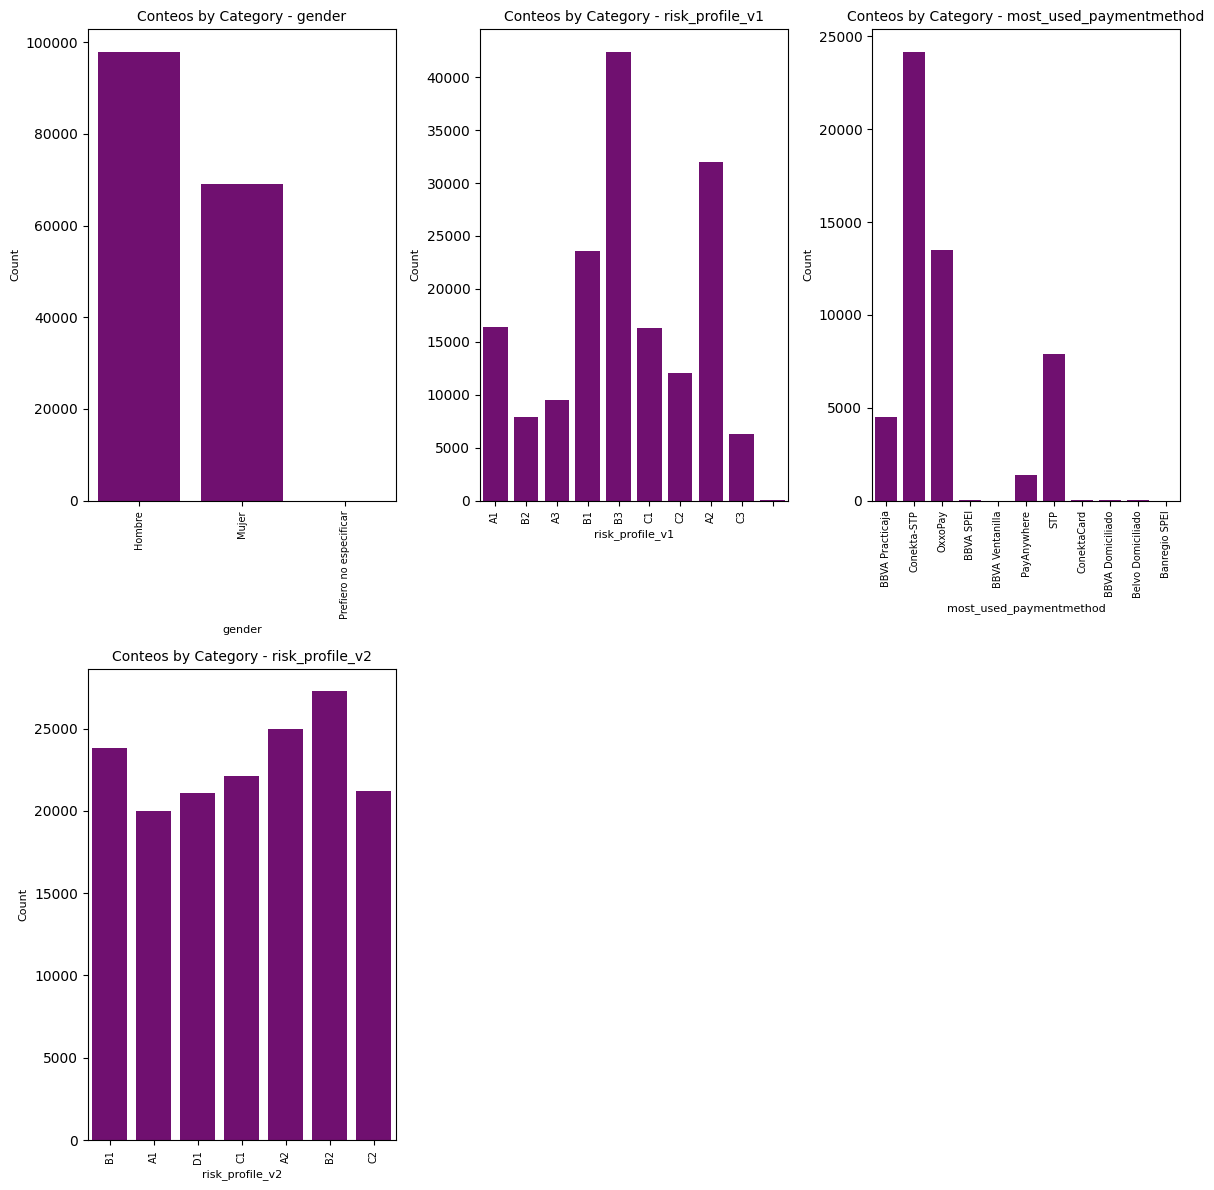

In [527]:
import matplotlib.pyplot as plt
import seaborn as sns

n_cols = 3
n_rows = 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 12))
axes = axes.flatten()

# Plot each categorical feature in the grid
for i, col in enumerate(df_categoric):
    sns.countplot(data=df_categoric, x=col, ax=axes[i], color='purple')
    axes[i].set_title(f'Conteos by Category - {col}', fontsize=10)
    axes[i].set_xlabel(col, fontsize=8)
    axes[i].set_ylabel('Count', fontsize=8)
    axes[i].tick_params(axis='x', rotation=90, labelsize=7)

# Hide any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# <font color='#8789ed' face='Tahoma' size=5>Análisis de variables correlacionadas, entendimiento y selección</font> 

#### <font color='#b33b3b' face='Monaco' size=5>max_overdue vs days_of_worst_overdue</font> 

In [ ]:
df_fc = df[['idobservation', 'id_userv3','max_overdue','days_of_worst_overdue']][(df['num_atrato_credits']==1)&(~df['max_overdue'].isna())]
df_fc['diff']=df_fc['max_overdue']-df_fc['days_of_worst_overdue']
df_fc.describe()

,id_userv3,max_overdue,days_of_worst_overdue,diff
count,63262.000000,63262.000000,63262.000000,63262.0
mean,252365.759145,14.427492,14.427492,0.0
std,174833.403033,20.113227,20.113227,0.0
min,6.000000,1.000000,1.000000,0.0
25%,98824.000000,3.000000,3.000000,0.0
50%,235937.000000,8.000000,8.000000,0.0
75%,381703.000000,17.000000,17.000000,0.0
max,701346.000000,473.000000,473.000000,0.0


In [ ]:
df[df['idobservation'].isin(df_fc[df_fc['diff']<0]['idobservation'].to_list())][['id_userv3','payment_history','max_overdue','days_of_worst_overdue']]

,id_userv3,payment_history,max_overdue,days_of_worst_overdue


Revisar los 129 casos donde son diferentes (TEORÍA, MÁS DE UN CRÉDITO AL MISMO TIEMPO), por lo demás quedarse con **days_of_worst_overdue**

#### <font color='#b33b3b' face='Monaco' size=5>current_debt vs pct_credit_maturity</font>

In [ ]:
df_sc = df[['idobservation','current_debt','pct_credit_maturity']]
df_sc

,idobservation,current_debt,pct_credit_maturity
0,3106-12,NaN,NaN
1,6229-5,0.724,0.276
2,7379-5,0.874,0.126
3,9534-7,0.724,0.276
4,9534-6,0.783,0.217
...,...,...,...
166628,1876928-1,NaN,NaN
166629,1881781-1,0.940,0.060
166630,1881124-1,NaN,NaN
166631,1888952-1,NaN,NaN


Parece que al sumarlas da 1, por lo que son complementarias, hacemos la comprobación.

In [ ]:
df_sc['sum_pct'] = df_sc['current_debt'] + df_sc['pct_credit_maturity']
df_sc['sum_pct'].describe()

/tmp/ipykernel_768/1783838561.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sc['sum_pct'] = df_sc['current_debt'] + df_sc['pct_credit_maturity']


count    152787.000000
mean          1.000001
std           0.000027
min           0.999000
25%           1.000000
50%           1.000000
75%           1.000000
max           1.001000
Name: sum_pct, dtype: float64

SELECCIÓN :  tienen la misma correlación, quitarla del modelo, puede usarse para la segmentación final de los clientes

#### <font color='#b33b3b' face='Monaco' size=5>granted_credit_amount vs max_overdue_amount vs monthly_payment</font>

In [ ]:
df_tc = df[['idobservation','granted_credit_amount', 'max_overdue_amount','montlhy_payment']]
df_tc = df_tc[~df_tc['max_overdue_amount'].isna()]
df_tc

,idobservation,granted_credit_amount,max_overdue_amount,montlhy_payment
1,6229-5,5500.0,683.875142,683.875142
2,7379-5,8500.0,840.683317,690.683317
3,9534-7,11000.0,1113.774045,966.887023
4,9534-6,11000.0,1113.774045,966.887023
5,9686-3,10999.0,1116.799124,966.799124
...,...,...,...,...
166606,1823393-2,43999.0,4220.830000,4220.830000
166608,1824586-2,1285.0,797.090000,497.090000
166610,1829929-2,18100.0,1640.020000,1640.020000
166620,1837334-1,7999.0,1424.010000,1424.100000


In [ ]:
df_tc['max_overdue_to_monthly_payment_ratio'] = df_tc['max_overdue_amount']/df_tc['montlhy_payment']
df_tc['max_overdue_to_monthly_payment_ratio'].describe()

count    115868.000000
mean          1.027817
std           0.281705
min           0.048751
25%           1.000000
50%           1.042085
75%           1.150510
max          10.837964
Name: max_overdue_to_monthly_payment_ratio, dtype: float64

In [ ]:
df_tc[df_tc['max_overdue_to_monthly_payment_ratio']<1].describe()

,granted_credit_amount,max_overdue_amount,montlhy_payment,max_overdue_to_monthly_payment_ratio
count,28306.000000,28306.000000,28306.000000,28306.000000
mean,14726.103177,1310.606933,2020.584768,0.687383
std,12907.230645,1033.177350,1614.195018,0.200099
min,700.000000,79.000000,148.460000,0.048751
25%,6449.000000,697.112500,1040.562500,0.501683
50%,10398.000000,1065.150000,1593.140000,0.625173
75%,18200.000000,1600.000000,2475.630000,0.892156
max,200000.000000,20000.000000,36938.950000,1.000000


La mayoría de las personas deben 1 mensualidad, pero hay gente que debe menos

SUGERENCIA: Usar monto del préstamo para segmentar o el pago mensual.

NOTA: Recordar que los clientes a veces pagan en cuotas una mensualidad, por la que si deben haber casos donde el max_overdue amount sea distinto de la cuota mensual. Quizá usar ratio en lugar de valores por separado

#### <font color='#b33b3b' face='Monaco' size=5>historical_overdue_atrato_credits vs num_atrato_credits

 num_atrato_credits</font>

In [ ]:
df['num_atrato_credits'].value_counts(normalize=True)*100

num_atrato_credits
1.0     55.513071
2.0     24.055944
3.0     11.794472
4.0      5.049371
5.0      2.192743
6.0      0.835559
7.0      0.328941
8.0      0.148864
9.0      0.037816
10.0     0.028812
12.0     0.006003
11.0     0.004802
15.0     0.001201
17.0     0.001201
16.0     0.000600
13.0     0.000600
Name: proportion, dtype: float64

In [ ]:
df_cc = df[['num_atrato_credits','historical_overdue_atrato_credits']]
df_cc['diff'] = df_cc['num_atrato_credits']-df_cc['historical_overdue_atrato_credits']
df_cc[df_cc['diff']==0].shape[0]/df.shape[0]*100

/tmp/ipykernel_768/2997433811.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cc['diff'] = df_cc['num_atrato_credits']-df_cc['historical_overdue_atrato_credits']


87.8823522351515

El 93 % de la población se ha atrasado en todos sus créditos, pueden no haber llegado a un bucket de mora de cobranza.

Quizá hacer un ratio o eliminarla del modelo

#### <font color='#b33b3b' face='Monaco' size=5>paid_late_comission_amount vs pending_late_comission </font>

Por definición son conceptos diferentes, pueden estar correlacionadas debido a que son múltiplos de 300 amnbas variables. Una cosa es cuantas comisiones debe y cuántas ha pagado, puede compararse vs el número de veces que se ha atrasado para ver el porcentaje de comisiones ha pagado.